#### Project 3 - Classify your own data

For this project we're going to explore some of the new topics since the last project including Decision Trees and Un-supervised learning. The final part of the project will ask you to perform your own data science project to classify a new dataset.



## Submission Details

**Project is due June 9th at 11:59 pm (Thursday Midnight). To submit the project, please save the notebook
as a pdf file and submit the assignment via Gradescope. In addition, make sure that
all figures are legible and suﬀiciently large. For best pdf results, we recommend downloading [Latex](https://www.latex-project.org/) and print the notebook using Latex.**

## Loading Essentials and Helper Functions 

In [5]:
#Here are a set of libraries we imported to complete this assignment. 
#Feel free to use these or equivalent libraries for your implementation
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # this is used for the plot the graph 
import matplotlib
import os
import time
#Sklearn classes
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn import metrics
from sklearn.metrics import confusion_matrix,silhouette_score
import sklearn.metrics.cluster as smc
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder ,LabelEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_blobs

from matplotlib import pyplot
import itertools

%matplotlib inline

#Sets random seed
import random 
random.seed(42) 

In [644]:
#Helper functions
def draw_confusion_matrix(y, yhat, classes):
    '''
        Draws a confusion matrix for the given target and predictions
        Adapted from scikit-learn and discussion example.
    '''
    plt.cla()
    plt.clf()
    matrix = confusion_matrix(y, yhat)
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.YlOrBr)
    plt.title("Confusion Matrix")
    plt.colorbar()
    num_classes = len(classes)
    plt.xticks(np.arange(num_classes), classes, rotation=0)
    plt.yticks(np.arange(num_classes), classes)
    plt.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)    
    fmt = 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.gca().xaxis.set_label_position('top')
    plt.tight_layout()
    plt.show()
    
def heatmap(data, row_labels, col_labels, figsize = (20,12), cmap = "YlGn",
            cbar_kw={}, cbarlabel="", valfmt="{x:.2f}",
            textcolors=("black", "white"), threshold=None):
    """
    Create a heatmap from a numpy array and two lists of labels. 
    
    Taken from matplotlib example.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cmap
        A string that specifies the colormap to use. Look at matplotlib docs for information.
        Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
    """

    plt.figure(figsize = figsize)
    ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data,cmap=cmap)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    
    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)


def make_meshgrid(x, y, h=0.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = plt.contourf(xx, yy, Z, **params)
    return out

def draw_contour(x,y,clf, class_labels = ["Negative", "Positive"]):
    """
    Draws a contour line for the predictor
    
    Assumption that x has only two features. This functions only plots the first two columns of x.
    
    """
    
    X0, X1 = x[:, 0], x[:, 1]
    xx0, xx1 = make_meshgrid(X0,X1)
    
    plt.figure(figsize = (10,6))
    plot_contours(clf, xx0, xx1, cmap="PiYG", alpha=0.8)
    scatter=plt.scatter(X0, X1, c=y, cmap="PiYG", s=30, edgecolors="k")
    plt.legend(handles=scatter.legend_elements()[0], labels=class_labels)

    plt.xlim(xx0.min(), xx0.max())
    plt.ylim(xx1.min(), xx1.max())
    


# Example Project using new techniques 

Since project 2, we have learned about a few new models for supervised learning(Decision Trees and Neural Networks) and un-supervised learning (Clustering and PCA). In this example portion, we will go over how to implement these techniques using the Sci-kit learn library.

## Load and Process Example Project Data


For our example dataset, we will use the [Breast Cancer Wisconsin Dataset](https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data) to determine whether a mass found in a body is benign or malignant. Since this dataset was used as an example in project 2, you should be fairly familiar with it.

Feature Information:

Column 1: ID number

Column 2: Diagnosis (M = malignant, B = benign)

Ten real-valued features are computed for each cell nucleus:

    1. radius (mean of distances from center to points on the perimeter)
    2. texture (standard deviation of gray-scale values)
    3. perimeter
    4. area
    5. smoothness (local variation in radius lengths)
    6. compactness (perimeter^2 / area - 1.0)
    7. concavity (severity of concave portions of the contour)
    8. concave points (number of concave portions of the contour)
    9. symmetry
    10. fractal dimension ("coastline approximation" - 1)

Due to the statistical nature of the test, we are not able to get exact measurements of the previous values. Instead, the dataset contains the mean and standard error of the real-valued features. 

Columns 3-12 present the mean of the measured values

Columns 13-22 present the standard error of the measured values

In [645]:
#Preprocess Data

#Load Data
data = pd.read_csv('datasets/breast_cancer_data.csv')

#Drop id column
data = data.drop(["id"],axis= 1)

#Transform target feature into numerical
le = LabelEncoder() 
data['diagnosis'] = le.fit_transform(data['diagnosis'])

#Split target and data
y = data["diagnosis"]
x = data.drop(["diagnosis"],axis = 1)

#Train test split
train_raw, test_raw, target, target_test = train_test_split(x,y, test_size=0.2, stratify= y, random_state=0)

#Standardize data
#Since all features are real-valued, we only have one pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler())
])

#Transform raw data 
train = pipeline.fit_transform(train_raw)
test = pipeline.transform(test_raw) #Note that there is no fit calls

#Names of Features after Pipeline
feature_names = list(pipeline.get_feature_names_out(list(x.columns)))

In [646]:
target.value_counts()

0    285
1    170
Name: diagnosis, dtype: int64

In [647]:
#Baseline accuracy of using the majority class 
ct = target_test.value_counts()
print("Counts of each class in target_test: ")
print(ct)
print("Baseline Accuraccy of using Majority Class: ", np.max(ct)/np.sum(ct))

Counts of each class in target_test: 
0    72
1    42
Name: diagnosis, dtype: int64
Baseline Accuraccy of using Majority Class:  0.631578947368421


## Supervised Learning: Decision Tree


### Classification with Decision Tree

In [648]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(criterion="gini", random_state = 0)
clf.fit(train, target)
predicted = clf.predict(test)

Accuracy:    0.894737
Confusion Matrix: 
 [[63  9]
 [ 3 39]]


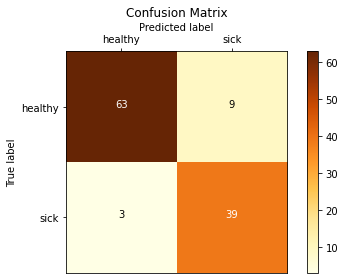

In [649]:
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))
print("Confusion Matrix: \n", metrics.confusion_matrix(target_test,predicted))
draw_confusion_matrix(target_test, predicted, ['healthy', 'sick'])

###  Parameters for Decision Tree Classifier

In Sci-kit Learn, the following are just some of the parameters we can pass into the Decision Tree Classifier:

- criterion: {‘gini’, ‘entropy’, ‘log_loss’} default="gini"
    - The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “log_loss” and “entropy” both for the Shannon information gain 
- splitter: {“best”, “random”}, default=”best”
    - The strategy used to choose the split at each node. “best” aims to find the best feature split amongst all features. "random" only looks for the best split amongst a random subset of features.
- max_depth: int, default = 2 {‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}, default=’lbfgs’
    - The maximum depth of the tree.
- min_samples_split: int or float, default=2
    - The minimum number of samples required to split an internal node. If int, then consider min_samples_split as the minimum number. If float, then min_samples_split is a fraction and ceil(min_samples_split * n_samples) are the minimum number of samples for each split.

### Visualizing Decision Trees

Scikit-learn allows us to visualize the decision tree to see what features it choose to split and what the result is. Note that if the condition in the node is true, you traverse the left edge of the node. Otherwise, you traverse the right edge.

[Text(0.5, 0.8333333333333334, 'concave points_mean <= 0.011\ngini = 0.468\nsamples = 100.0%\nvalue = [0.626, 0.374]'),
 Text(0.25, 0.5, 'area_mean <= 0.124\ngini = 0.101\nsamples = 61.5%\nvalue = [0.946, 0.054]'),
 Text(0.125, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.375, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.75, 0.5, 'concavity_mean <= 0.001\ngini = 0.202\nsamples = 38.5%\nvalue = [0.114, 0.886]'),
 Text(0.625, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.875, 0.16666666666666666, '\n  (...)  \n')]

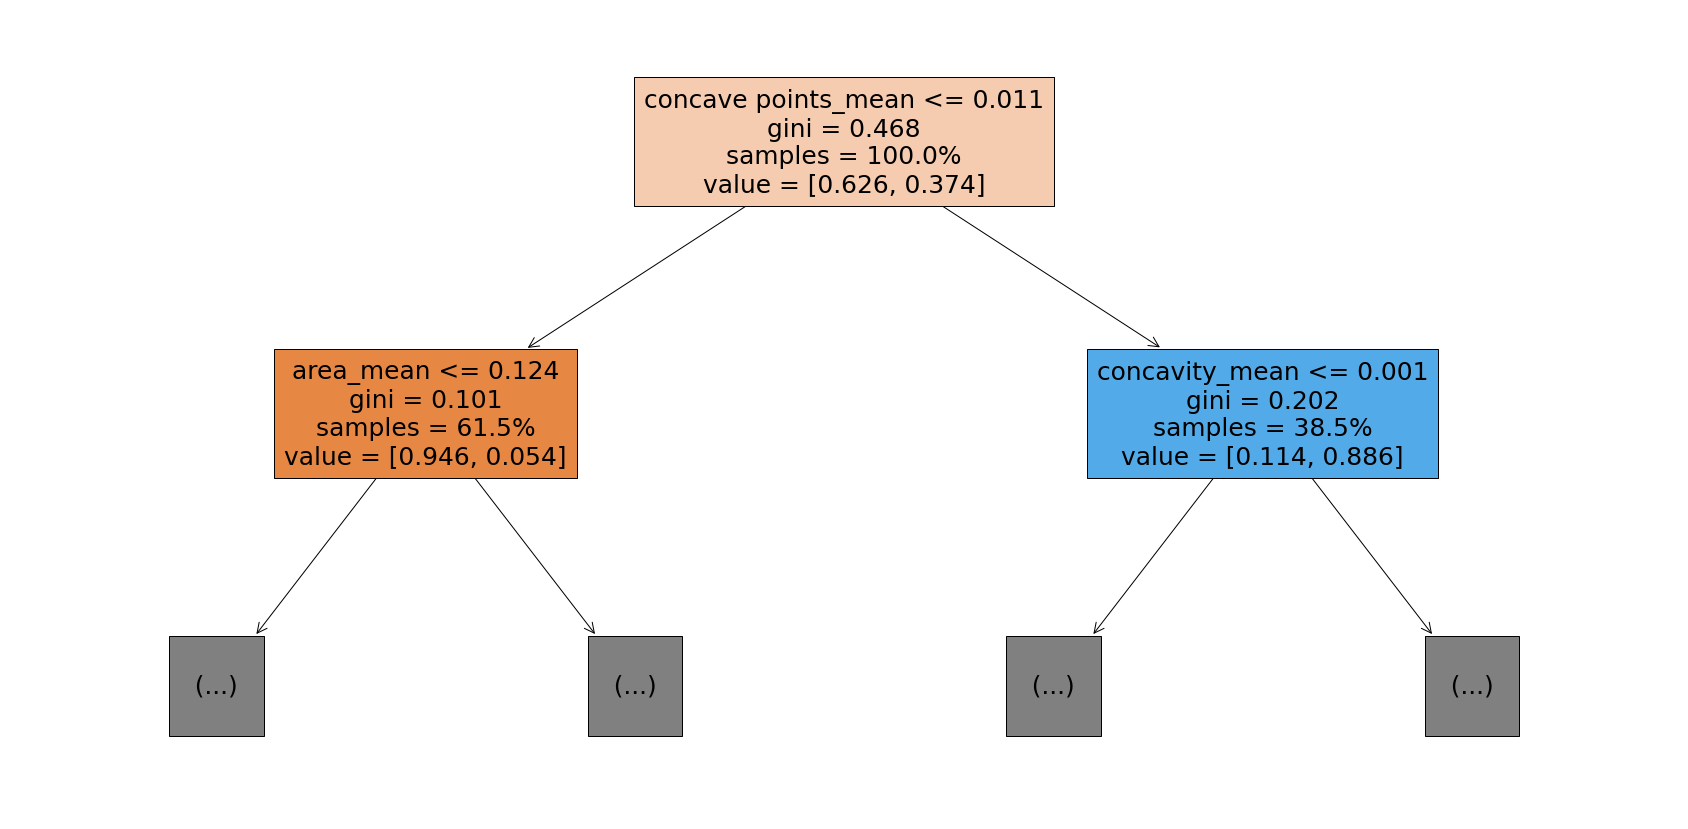

In [650]:
plt.figure(figsize = (30,15)) 
#Note that we have to pass the feature names into the plotting function to get the actual names
#We pass the column names through the pipeline in case any feature augmentation was made
#For example, a categorical feature will be split into multiple features with one hot encoding
#and this way assigns a name to each column based on the feature value and the original feature name
tree.plot_tree(clf,max_depth=1, proportion=True,feature_names=feature_names, filled=True)

We can even look at the tree in a textual format.

In [651]:
from sklearn.tree import export_text
r = export_text(clf, feature_names=feature_names)
print(r)

|--- concave points_mean <= 0.01
|   |--- area_mean <= 0.12
|   |   |--- area_se <= 0.04
|   |   |   |--- compactness_mean <= 0.59
|   |   |   |   |--- fractal_dimension_se <= -0.83
|   |   |   |   |   |--- fractal_dimension_se <= -0.84
|   |   |   |   |   |   |--- smoothness_se <= -1.22
|   |   |   |   |   |   |   |--- compactness_se <= -0.98
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- compactness_se >  -0.98
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- smoothness_se >  -1.22
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- fractal_dimension_se >  -0.84
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- fractal_dimension_se >  -0.83
|   |   |   |   |   |--- class: 0
|   |   |   |--- compactness_mean >  0.59
|   |   |   |   |--- symmetry_se <= 0.20
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- symmetry_se >  0.20
|   |   |   |   |   |--- class: 0
|   |   |--- area_se >  0.04
|   |   |   

### Feature Importance in Decision Trees

Decision Trees can also assign importance to features by measuring the average decrease in impurity (i.e. information gain) for each feature. The features with higher decreases are treated as more important. 

<AxesSubplot:>

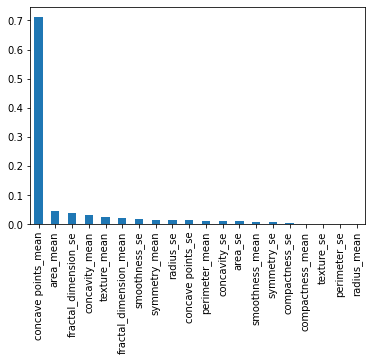

In [652]:
imp_pd = pd.Series(data = clf.feature_importances_ ,index = feature_names)
imp_pd= imp_pd.sort_values(ascending=False)
imp_pd.plot.bar()

We can clearly see that "concave points_mean" has the largest importance due to it providing the most reduction in the impurity.

### Visualizing decision boundaries for Decision Trees

Similar to project 2, lets see what decision boundaries that a Decision Tree creates. We use the two most correlated features to the target labels: concave_points_mean and perimeter_mean. 

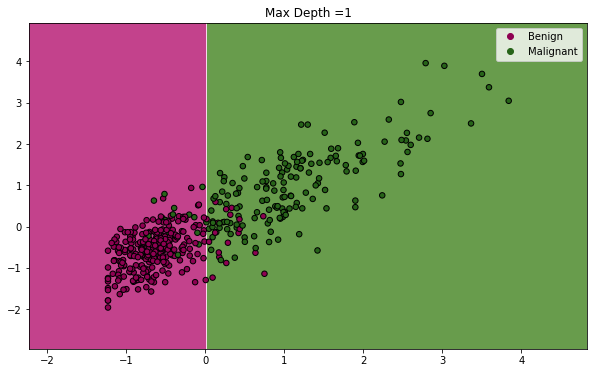

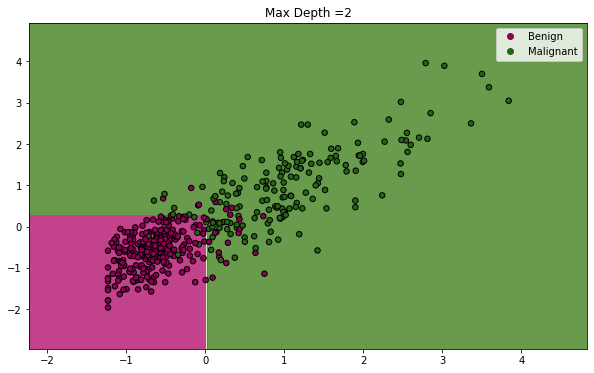

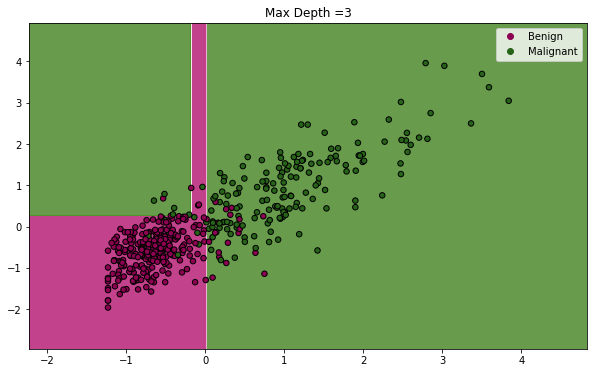

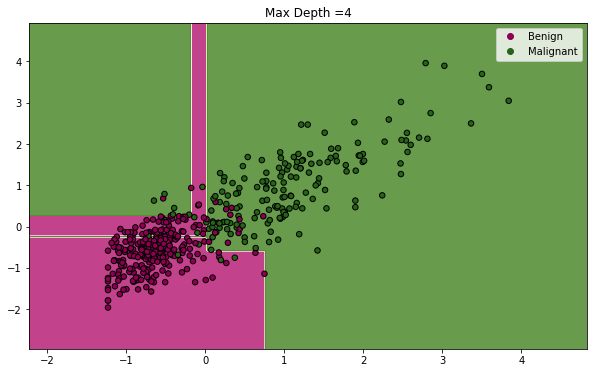

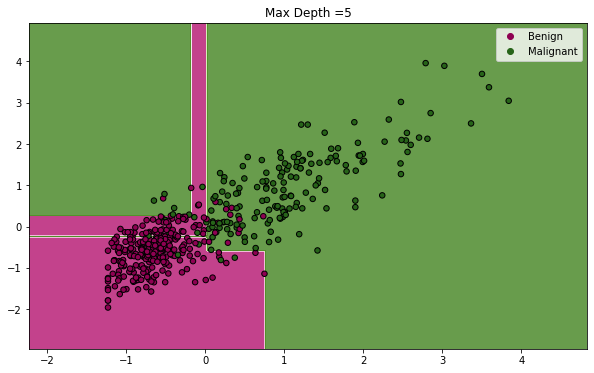

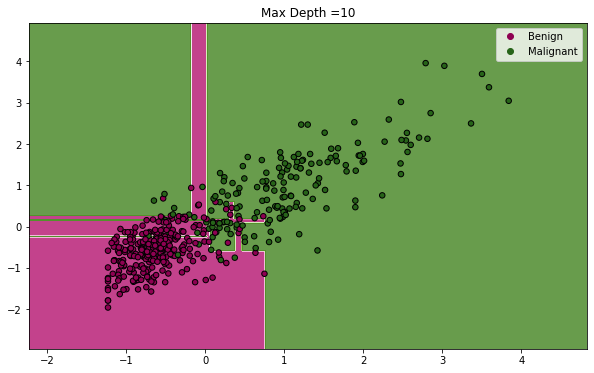

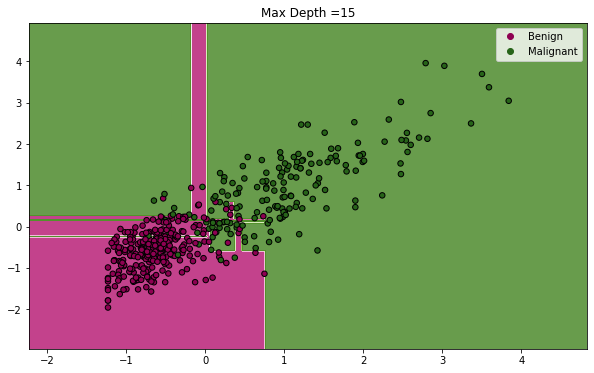

In [653]:
#Extract first two feature and use the standardscaler 
train_2 = StandardScaler().fit_transform(train_raw[['concave points_mean','perimeter_mean']])

depth  = [1,2,3,4,5,10,15]
for d in depth:
    dt = DecisionTreeClassifier(max_depth = d, min_samples_split=7) 
    dt.fit(train_2, target)
    draw_contour(train_2,target,dt,class_labels = ['Benign', 'Malignant'])
    
    plt.title(f"Max Depth ={d}")

We can see that the model gets more and more complex with increasing depth until it converges somewhere in between depth 10 and 15. 

## Supervised Learning: Multi-Layer Perceptron (MLP)

A neural network is a series of algorithms that endeavors to recognize underlying relationships in a set of data through a process that mimics the way the human brain operates. Neural networks are very powerful tools that are used a in a variety of applications including image and speech processing. In class, we have discussed one of the earliest types of neural networks known as a Multi-Layer Perceptron. 

![steps](jupyter_images/mlp_example.png)

### Using MLP for classification

In [654]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(100,), max_iter = 400)
clf.fit(train, target)
predicted = clf.predict(test)

/Users/brandonpai/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy:    0.947368
Confusion Matrix: 
 [[67  5]
 [ 1 41]]


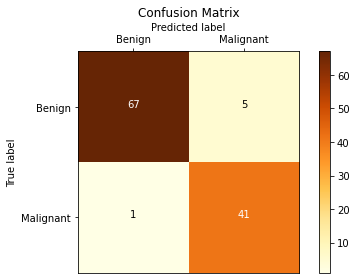

In [655]:
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))
print("Confusion Matrix: \n", metrics.confusion_matrix(target_test,predicted))
draw_confusion_matrix(target_test, predicted, ['Benign', 'Malignant'])

###  Parameters for MLP Classifier

In Sci-kit Learn, the following are just some of the parameters we can pass into MLP Classifier:

- hidden_layer_sizes: tuple, length = n_layers - 2, default=(100,)
    - The ith element represents the number of neurons in the ith hidden layer. 
- activation: {‘identity’, ‘logistic’, ‘tanh’, ‘relu’}, default=’relu’
    - Activation function for the hidden layer.
- alpha: float, default = 0.0001
    - Strength of the L2 regularization term. The L2 regularization term is divided by the sample size when added to the loss.
- max_iter: int, default=200
    - Maximum number of iterations taken for the solvers to converge.

### Visualizing decision boundaries for MLP

Now, lets see how the decision boundaries change as a function of both the activation function and the number of hidden layers.

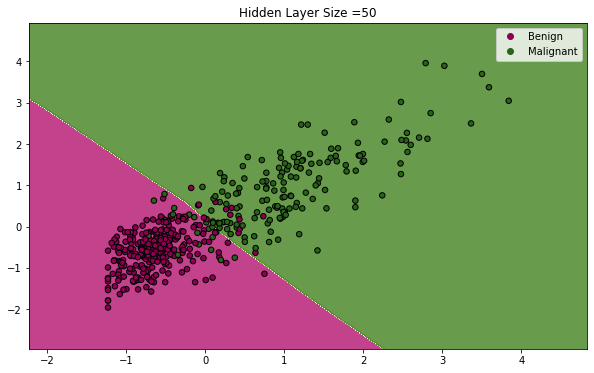

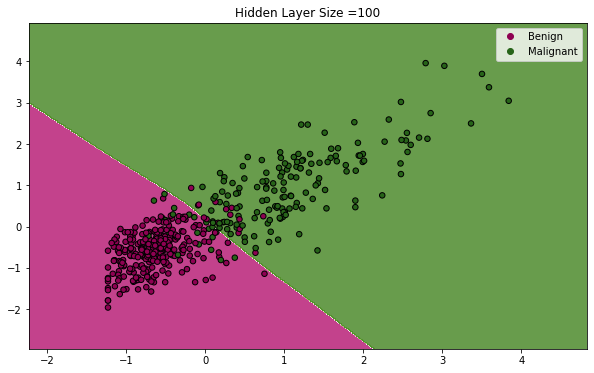

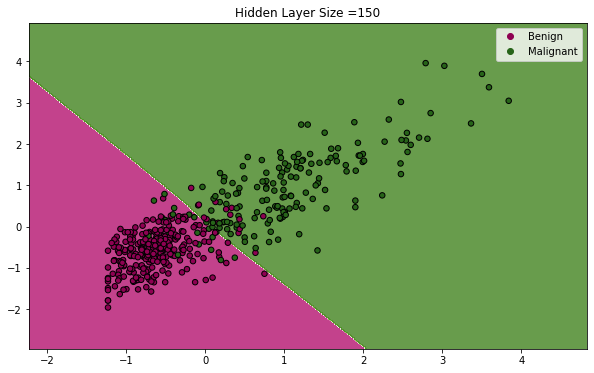

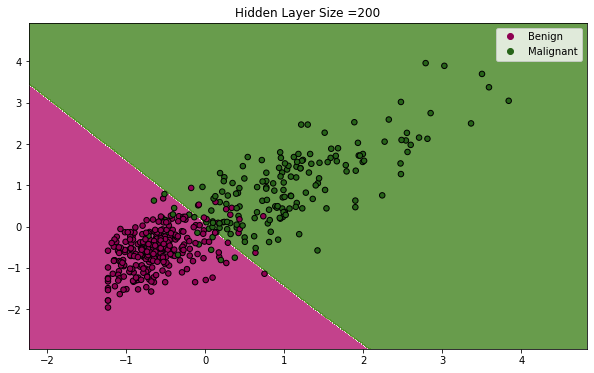

In [656]:
#Example of using the default Relu activation while altering the number of hidden layers
train_2 = StandardScaler().fit_transform(train_raw[['concave points_mean','perimeter_mean']])

layers  = [50,100,150,200]
for l in layers:
    mlp = MLPClassifier(hidden_layer_sizes=(l,), max_iter = 400)
    mlp.fit(train_2, target)
    draw_contour(train_2,target,mlp,class_labels = ['Benign', 'Malignant'])
    
    plt.title(f"Hidden Layer Size ={l}")

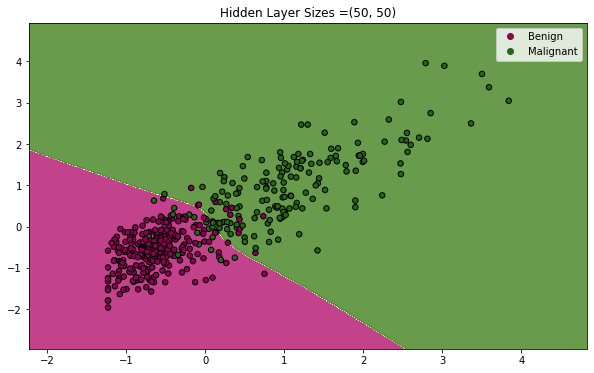

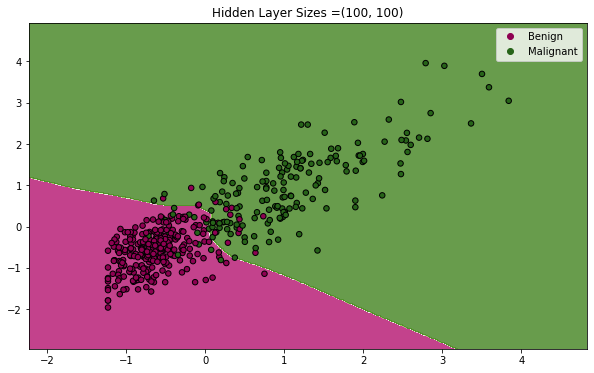

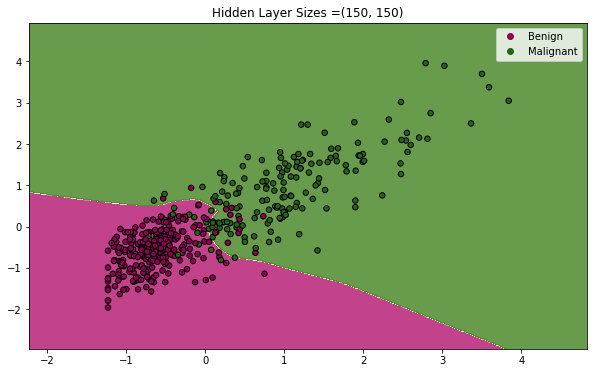

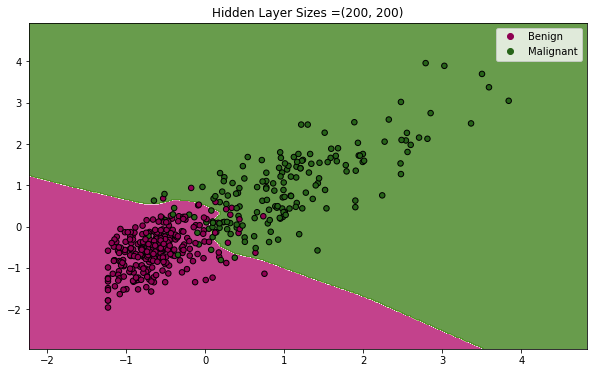

In [657]:
#Example of using the default Relu activation 
#while altering the number of hidden layers with 2 groups of hidden layers
train_2 = StandardScaler().fit_transform(train_raw[['concave points_mean','perimeter_mean']])

layers  = [50,100,150,200]
for l in layers:
    mlp = MLPClassifier(hidden_layer_sizes=(l,l), max_iter = 400)
    mlp.fit(train_2, target)
    draw_contour(train_2,target,mlp,class_labels = ['Benign', 'Malignant'])
    
    plt.title(f"Hidden Layer Sizes ={(l,l)}")

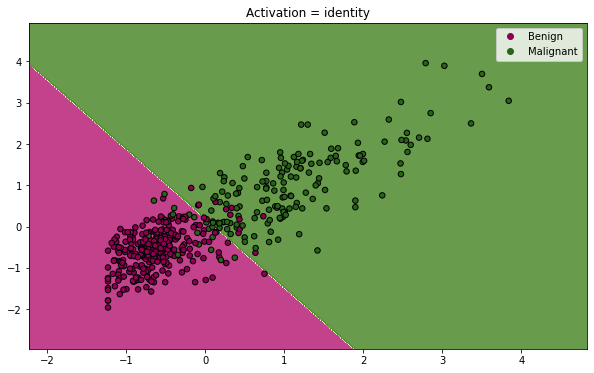

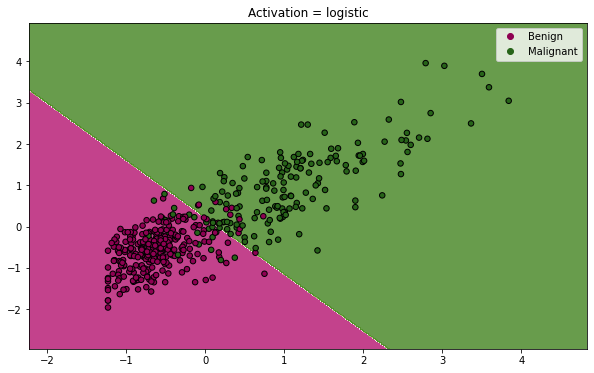

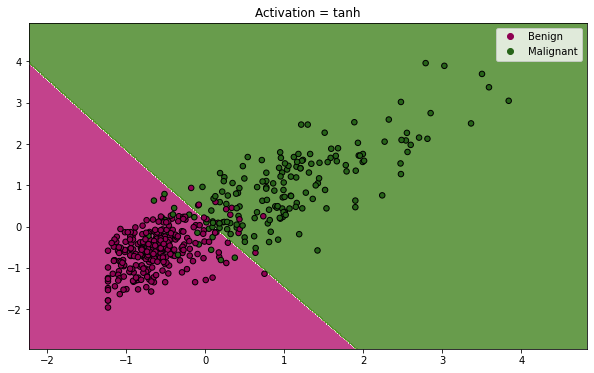

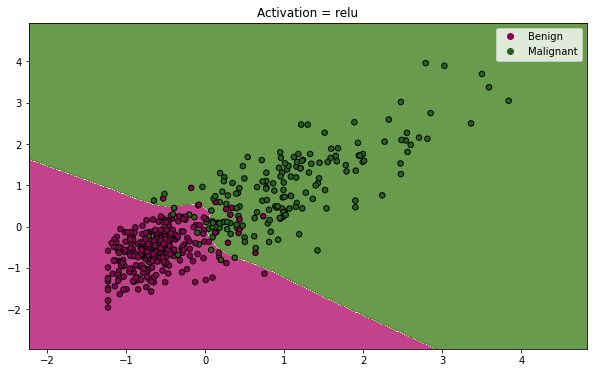

In [658]:
#Example of using 2 hidden layers of 100 units each with varying activations
train_2 = StandardScaler().fit_transform(train_raw[['concave points_mean','perimeter_mean']])

acts  = ['identity', 'logistic', 'tanh', 'relu']
for act in acts:
    mlp = MLPClassifier(hidden_layer_sizes=(100,100), activation = act, max_iter = 400)
    mlp.fit(train_2, target)
    draw_contour(train_2,target,mlp,class_labels = ['Benign', 'Malignant'])
    
    plt.title(f"Activation = {act}")

## Unsupervised learning: PCA

As shown in lecture, PCA is a valuable dimensionality reduction tool that can extract a small subset of valuable features. In this section, we shall demonstrate how PCA can extract important visual features from pictures of subjects faces. We shall use the [AT&T Database of Faces](https://www.kaggle.com/datasets/kasikrit/att-database-of-faces). This dataset contains 40 different subjects with 10 samples per subject which means we a dataset of 400 samples. 

We extract the images from the [scikit-learn dataset library](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_olivetti_faces.html#sklearn.datasets.fetch_olivetti_faces). The library imports the images (faces.data), the flatten array of images (faces.images), and which subject eacj image belongs to (faces.target). Each image is a 64 by 64 image with pixels converted to floating point values in [0,1].

### Eigenfaces

The following codes downloads and loads the face data. 

In [659]:
#Import faces from scikit library
faces = datasets.fetch_olivetti_faces()
print("Flattened Face Data shape:", faces.data.shape)
print("Face Image Data Shape:", faces.images.shape)
print("Shape of target data:", faces.target.shape)


Flattened Face Data shape: (400, 4096)
Face Image Data Shape: (400, 64, 64)
Shape of target data: (400,)


In [660]:
#Extract image shape for future use
im_shape = faces.images[0].shape

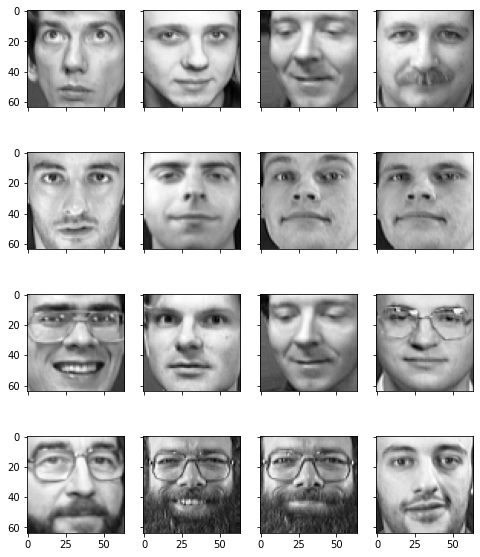

In [661]:
#Prints some example faces 
faceimages = faces.images[np.random.choice(len(faces.images),size= 16, replace = False)] # take random 16 images

fig, axes = plt.subplots(4,4,sharex=True,sharey=True,figsize=(8,10))
for i in range(16):
    axes[i%4][i//4].imshow(faceimages[i], cmap="gray")
plt.show()

Now, let us see what features we can extract from these face images.

In [662]:
#Perform PCA
from sklearn.decomposition import PCA
 
pca = PCA()
pca_pipe = Pipeline([("scaler",StandardScaler()), #Scikit learn PCA does not standardize so we need to add
               ("pca",pca)])
pca_pipe.fit(faces.data)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA())])

The following plots the top 30 PCA components with how much variance does this feature explain.

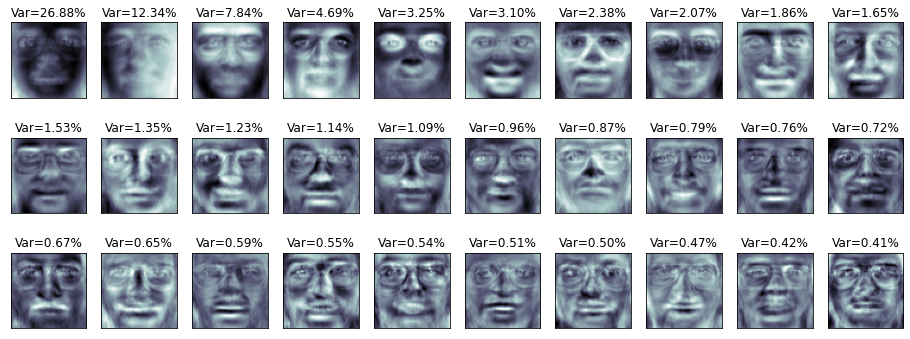

In [663]:
fig = plt.figure(figsize=(16, 6))
for i in range(30):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(pca.components_[i].reshape(im_shape),
              cmap=plt.cm.bone)
    ax.set_title(f"Var={pca.explained_variance_ratio_[i]:.2%}")

Amazing! We can see that the model has learned to focus on many features that we as humans also look at when trying to identify a face such as the nose,eyes, eyebrows, etc.

With this feature extraction, we can perform much more powerful learning. 

### Feature Extraction for Classification

Lets see if we can use PCA to improve the accuracy of the decision tree classifier.

Accuracy without PCA
Accuracy:    0.894737
Confusion Matrix: 
 [[63  9]
 [ 3 39]]


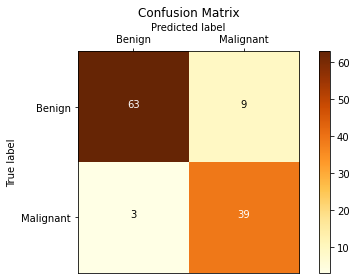

Accuracy with PCA
Accuracy:    0.912281
Confusion Matrix: 
 [[66  6]
 [ 4 38]]


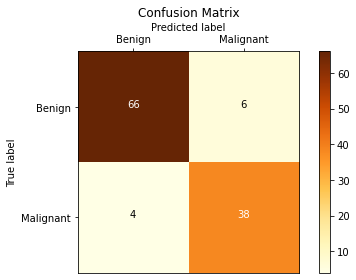

In [664]:
#Without PCA
clf = DecisionTreeClassifier(random_state=0)
clf.fit(train, target)
predicted = clf.predict(test)

print("Accuracy without PCA")
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))
print("Confusion Matrix: \n", metrics.confusion_matrix(target_test,predicted))
draw_confusion_matrix(target_test, predicted, ['Benign', 'Malignant'])

#With PCA
pca = PCA(n_components = 0.9) #Take components that explain at lest 90% variance
       
train_new = pca.fit_transform(train)
test_new = pca.transform(test)

clf_pca = DecisionTreeClassifier(random_state=0)
clf_pca.fit(train_new, target)
predicted = clf_pca.predict(test_new)

print("Accuracy with PCA")
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))
print("Confusion Matrix: \n", metrics.confusion_matrix(target_test,predicted))
draw_confusion_matrix(target_test, predicted, ['Benign', 'Malignant'])

In [665]:
print("Number of Features without PCA: ", train.shape[1])
print("Number of Features with PCA: ", train_new.shape[1])

Number of Features without PCA:  20
Number of Features with PCA:  7


Clearly, we get a much better accuracy for the model while using fewer features. But does the features the PCA thought were important the same features that the decision tree used. Lets look at the feature importance of the tree. The following plot numbers the first principal component as 0, the second as 1, and so forth.

<AxesSubplot:>

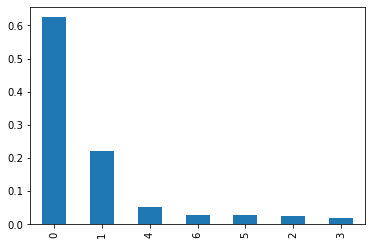

In [666]:
feature_names_new = list(range(train_new.shape[1]))
imp_pd = pd.Series(data = clf_pca.feature_importances_ ,index = feature_names_new)
imp_pd= imp_pd.sort_values(ascending=False)
imp_pd.plot.bar()

Amazingly, the first and second components were the most important features in the decision tree. Thus, we can claim that PCA has significantly improved the performance of our model. 

## Unsupervised learning: Clustering

Clustering is the task of grouping a set of objects in such a way that objects in the same group (called a cluster) are more similar (in some sense) to each other than to those in other groups. One major algorithm we learned in class is the K-Means algorithm.

### Evaluating K-Means performance

While there are many ways to evaluate the [performance measure of clustering algorithsm](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation), we will focus on the inertia score of the K-Means model. Inertia is another term for the sum of squared distances of samples to their closest cluster center. 

Let us look at how the Inertia changes as a function of the number of clusters for an artificial dataset.


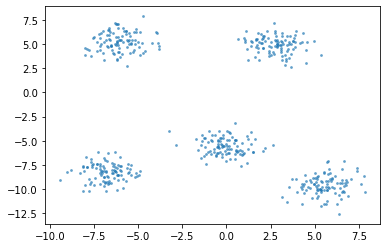

In [667]:
#Artifical Dataset
X, y = make_blobs(
    n_samples=500,
    n_features=2,
    centers=5,
    cluster_std=1,
    center_box=(-10.0, 10.0),
    shuffle=True,
    random_state=10,
)  # For reproducibility

plt.scatter(X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7,edgecolor="k")

In [668]:
ks = list(range(2,10))
inertia = []
for k in ks:
    kmeans = KMeans(n_clusters = k, init = 'k-means++', random_state = 0)
    kmeans.fit(X)
    # inertia method returns wcss for that model
    inertia.append(kmeans.inertia_)
    print(f"Inertia for K = {k}: {kmeans.inertia_}")

Inertia for K = 2: 13293.997460961546
Inertia for K = 3: 7169.578996856773
Inertia for K = 4: 3247.8674040695832
Inertia for K = 5: 872.8554968701878
Inertia for K = 6: 803.846686425823
Inertia for K = 7: 739.5236191503768
Inertia for K = 8: 690.2530283275607
Inertia for K = 9: 614.5138307338655


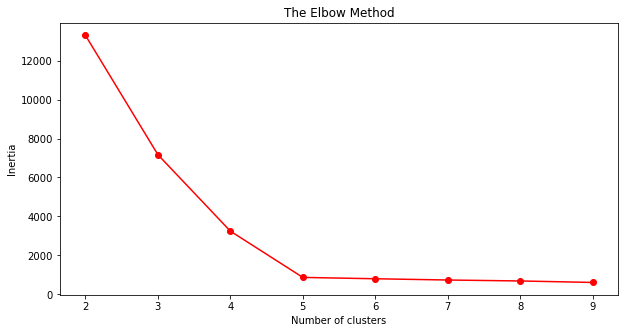

In [669]:
plt.figure(figsize=(10,5))
plt.plot(ks, inertia,marker='o',color='red')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

From the plot, we can see that when the number of clusters of K-means is the correct number of clusters, Inertia starts decreasing at a much slower rate. This creates a kind of elbow shape in the graph. For K-means clustering, the elbow method selects the number of clusters where the elbow shape is formed. In this case, we see that this method would produce the correct number of clusters.

Lets try it on the cancer dataset.

In [670]:
ks = list(range(2,30))
inertia = []
for k in ks:
    kmeans = KMeans(n_clusters = k, init = 'k-means++', random_state = 0)
    kmeans.fit(train)
    # inertia method returns wcss for that model
    inertia.append(kmeans.inertia_)
    print(f"Inertia for K = {k}: {kmeans.inertia_}")

Inertia for K = 2: 6381.278325955922
Inertia for K = 3: 5508.621446593709
Inertia for K = 4: 4972.231721973118
Inertia for K = 5: 4507.26713736607
Inertia for K = 6: 4203.777246823878
Inertia for K = 7: 3942.659550896411
Inertia for K = 8: 3745.1124228292692
Inertia for K = 9: 3532.7225156022073
Inertia for K = 10: 3371.033467027838
Inertia for K = 11: 3232.472758070737
Inertia for K = 12: 3135.1944201924534
Inertia for K = 13: 3033.3838427786477
Inertia for K = 14: 2958.3200036360367
Inertia for K = 15: 2893.798763511904
Inertia for K = 16: 2767.804761705547
Inertia for K = 17: 2737.4747101790635
Inertia for K = 18: 2662.1203080706655
Inertia for K = 19: 2617.90890694005
Inertia for K = 20: 2553.961378449726
Inertia for K = 21: 2491.9133737078346
Inertia for K = 22: 2448.777623600997
Inertia for K = 23: 2391.644588540416
Inertia for K = 24: 2374.1345787190176
Inertia for K = 25: 2334.794010981073
Inertia for K = 26: 2267.993521706617
Inertia for K = 27: 2233.585453239129
Inertia for K

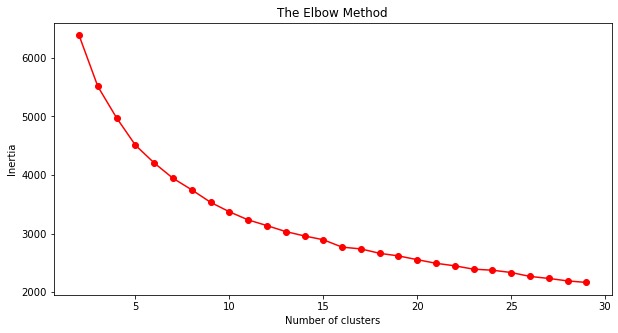

In [671]:
plt.figure(figsize=(10,5))
plt.plot(ks, inertia,marker='o',color='red')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

Here we see that the elbow is not as cleanly defined. This may be due to the dataset not being a good fit for K-means. Regardless, we can still apply the elbow method by noting that the slow down happens around 7~14.

### Kmeans on Eigenfaces

Now, lets see how K-means performs in clustering the face data with PCA.

In [672]:
from sklearn.cluster import KMeans

n_clusters = 10 #We know there are 10 subjects
km = KMeans(n_clusters  = n_clusters,random_state=0)

pipe= Pipeline([("scaler",StandardScaler()), #First standardize
               ("pca",PCA()), #Transform using pca
         ("kmeans", km )]) #Then apply k means

In [673]:
clusters = pipe.fit_predict(faces.data)
print(clusters)

[3 6 3 4 6 4 3 3 3 6 5 5 5 5 5 5 5 5 5 5 1 1 5 1 4 1 4 4 6 6 5 5 5 3 6 4 3
 5 5 6 4 1 1 4 4 4 4 4 4 3 3 3 3 3 3 3 3 3 3 3 7 7 3 4 7 3 7 7 3 7 0 6 3 6
 3 3 6 3 3 6 1 1 1 4 4 4 4 4 1 6 6 6 6 6 6 6 6 6 4 3 0 0 0 0 0 0 0 0 0 0 4
 1 1 1 1 4 1 6 6 4 5 5 4 4 5 5 4 4 5 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 8 3 3 3 3 8 6 8 3 3 4 4 1 1 4 4 4 4 4 4 3 6 4 6 3 3 3 3 3 3 7 7 7 7 7
 7 7 7 7 7 9 9 9 4 4 4 4 4 4 9 9 9 9 9 9 9 4 8 9 4 2 2 2 2 2 2 2 2 2 2 3 6
 1 4 1 4 1 6 4 4 8 8 8 8 5 8 8 8 8 8 6 5 6 5 5 5 6 4 5 6 1 1 1 1 1 1 3 1 1
 5 5 5 5 5 5 5 5 5 5 5 5 1 5 5 5 5 5 5 1 4 2 2 2 9 4 4 9 8 2 2 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 7 7 7 7 7 7 5 7 7 7 9 9 9 9 9 9 9 9 9 9 2 2 2
 2 2 2 2 2 2 2 9 9 9 9 4 6 6 1 4 4 3 8 8 8 7 8 8 8 8 8 1 1 1 1 1 1 1 1 1 1
 4 1 1 6 1 4 6 6 4 1 2 2 2 2 2 2 2 2 2 2 6 4 3 4 3 1 4 1 4 4]


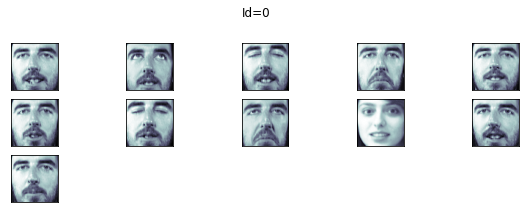

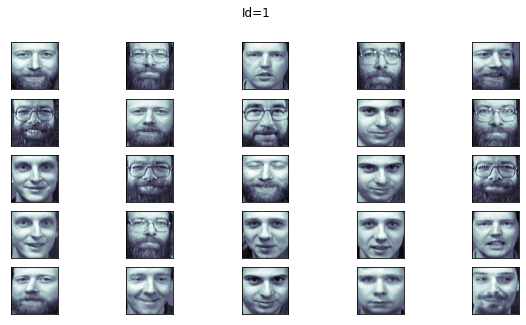

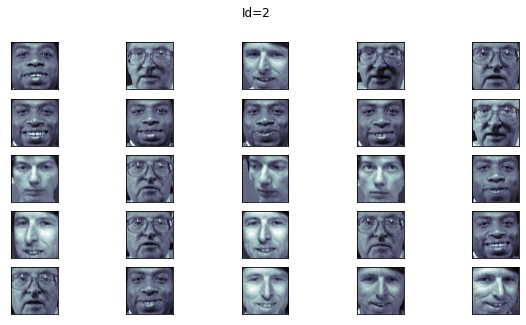

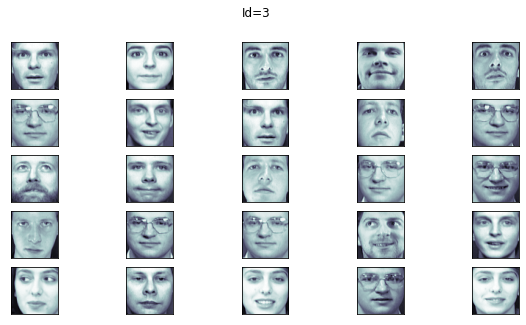

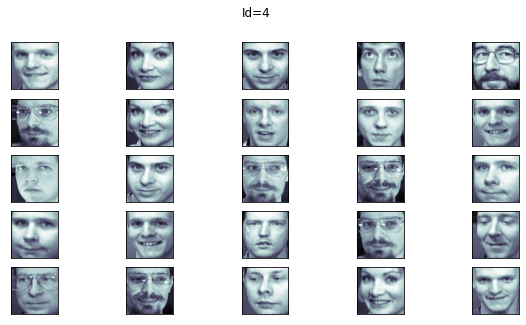

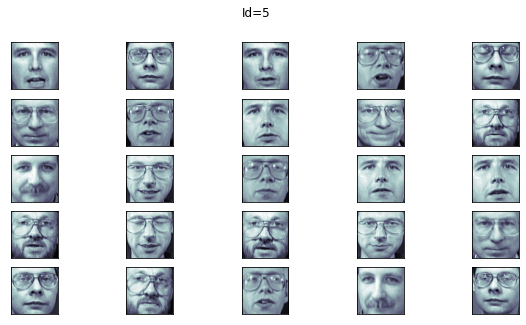

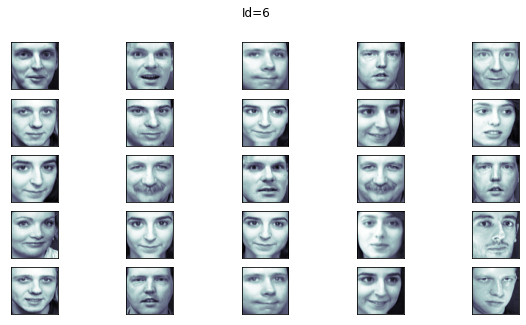

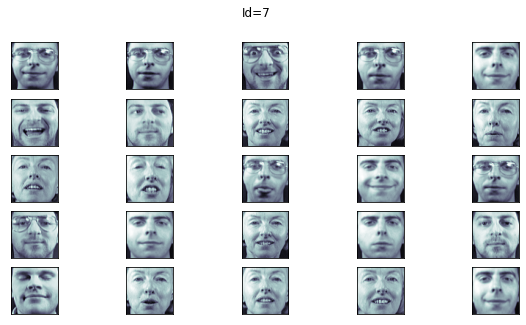

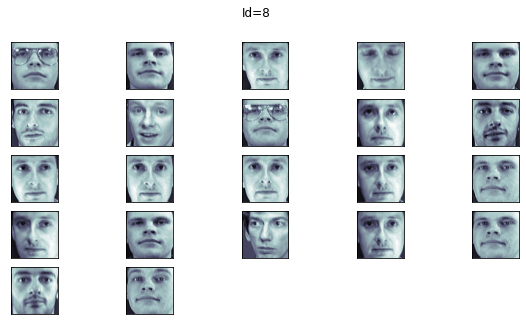

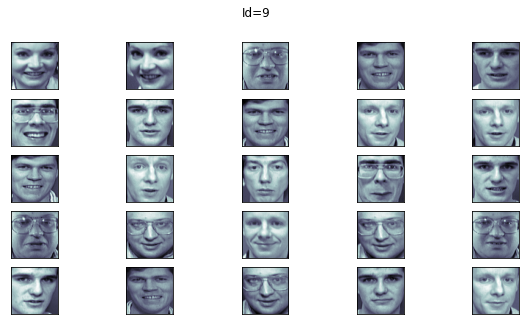

In [674]:
for labelID in range(n_clusters):
    # find all indexes into the `data` array that belong to the
    # current label ID, then randomly sample a maximum of 25 indexes
    # from the set
    idxs = np.where(clusters == labelID)[0]
    idxs = np.random.choice(idxs, size=min(25, len(idxs)),
        replace=False)

    # Extract the sampled indexes
    id_face = faces.images[idxs]

    #Plots sampled faces
    fig = plt.figure(figsize=(10,5))
    for i in range(min(25,len(idxs))):
        ax = fig.add_subplot(5, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(id_face[i],
                  cmap=plt.cm.bone)
    fig.suptitle(f"Id={labelID}")

While the algorithm isn't perfect, we can see that K-means with PCA is picking up on some facial similarity or similar expressions. 

# (100 pts) Todo: Use new methods to classify heart disease

To compare how these new models perform with the other models discussed in the course, we will apply these new models on the heart disease dataset that was used in project 2.

## Background: The Dataset (Recap)

For this exercise we will be using a subset of the UCI Heart Disease dataset, leveraging the fourteen most commonly used attributes. All identifying information about the patient has been scrubbed. You will be asked to classify whether a <b>patient is suffering from heart disease</b> based on a host of potential medical factors.

The dataset includes 14 columns. The information provided by each column is as follows:
<ul>
    <li><b>age:</b> Age in years</li>
    <li><b>sex:</b> (1 = male; 0 = female)</li>
    <li><b>cp:</b> Chest pain type (0 = asymptomatic; 1 = atypical angina; 2 = non-anginal pain; 3 = typical angina)</li>
    <li><b>trestbps:</b> Resting blood pressure (in mm Hg on admission to the hospital)</li>
    <li><b>chol:</b> cholesterol in mg/dl</li>
    <li><b>fbs</b> Fasting blood sugar > 120 mg/dl (1 = true; 0 = false)</li>
    <li><b>restecg:</b> Resting electrocardiographic results (0= showing probable or definite left ventricular hypertrophy by Estes' criteria; 1 = normal; 2 = having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV))</li>
    <li><b>thalach:</b> Maximum heart rate achieved</li>
    <li><b>exang:</b> Exercise induced angina (1 = yes; 0 = no)</li>
    <li><b>oldpeak:</b> Depression induced by exercise relative to rest</li>
    <li><b>slope:</b> The slope of the peak exercise ST segment (0 = downsloping; 1 = flat; 2 = upsloping)</li>
    <li><b>ca:</b> Number of major vessels (0-3) colored by flourosopy</li>
    <li><b>thal:</b> 1 = normal; 2 = fixed defect; 7 = reversable defect</li>
    <li><b><u>sick:</u></b> Indicates the presence of Heart disease (True = Disease; False = No disease)</li>
</ul>
    

## Preprocess Data

This part is done for you since you would have already completed it in project 2. Use the train, target, test, and target_test for all future parts. We also provide the column names for each transformed column for future use.

In [675]:
#Preprocess Data

#Load Data
data = pd.read_csv('datasets/heartdisease.csv')

#Transform target feature into numerical
le = LabelEncoder() 
data['target'] = le.fit_transform(data['sick'])
data = data.drop(["sick"], axis =1)

#Split target and data
y = data["target"]
x = data.drop(["target"],axis = 1)

#Train test split
#40% in test data as was in project 2
train_raw, test_raw, target, target_test = train_test_split(x,y, test_size=0.4, stratify= y, random_state=0)

#Feature Transformation
#This is the only change from project 2 since we replaced standard scaler to minmax
#This was done to ensure that the numerical features were still of the same scale
#as the one hot encoded features
num_pipeline = Pipeline([
    ('minmax', MinMaxScaler()) 
])

heart_num = train_raw.drop(['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca','thal'], axis=1)
numerical_features = list(heart_num)
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca','thal']

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, numerical_features),
    ("cat", OneHotEncoder(categories='auto'), categorical_features),
])

#Transform raw data 
train = full_pipeline.fit_transform(train_raw)
test = full_pipeline.transform(test_raw) #Note that there is no fit calls

#Extracts features names for each transformed column
feature_names = full_pipeline.get_feature_names_out(list(x.columns))

In [676]:
print("Column names after transformation by pipeline: ", feature_names)

Column names after transformation by pipeline:  ['num__age' 'num__trestbps' 'num__chol' 'num__thalach' 'num__oldpeak'
 'cat__sex_0' 'cat__sex_1' 'cat__cp_0' 'cat__cp_1' 'cat__cp_2' 'cat__cp_3'
 'cat__fbs_0' 'cat__fbs_1' 'cat__restecg_0' 'cat__restecg_1'
 'cat__restecg_2' 'cat__exang_0' 'cat__exang_1' 'cat__slope_0'
 'cat__slope_1' 'cat__slope_2' 'cat__ca_0' 'cat__ca_1' 'cat__ca_2'
 'cat__ca_3' 'cat__ca_4' 'cat__thal_0' 'cat__thal_1' 'cat__thal_2'
 'cat__thal_3']


The following shows the baseline accuracy of simply classifying every sample as the majority class.

In [677]:
#Baseline accuracy of using the majority class 
ct = target_test.value_counts()
print("Counts of each class in target_test: ")
print(ct)
print("Baseline Accuraccy of using Majority Class: ", np.max(ct)/np.sum(ct))

Counts of each class in target_test: 
0    66
1    56
Name: target, dtype: int64
Baseline Accuraccy of using Majority Class:  0.5409836065573771


## (25 pts) Decision Trees

### [5 pts] Apply  Decision Tree on Train Data

Apply the decision tree on the **train data** with default parameters of the DecisionTreeClassifier. **Report the accuracy and print the confusion matrix**. Make sure to use random_state = 0 so that your results match ours.

In [678]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(criterion="gini", random_state = 0)
clf.fit(train, target)
predicted = clf.predict(test)

### [5 pts] Visualize the Decision Tree

Visualize the first two layers of the decision tree that you trained.

Accuracy:    0.696721
Confusion Matrix: 
 [[53 13]
 [24 32]]


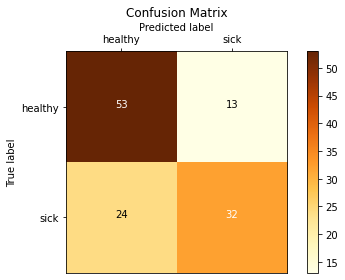

In [679]:
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))
print("Confusion Matrix: \n", metrics.confusion_matrix(target_test,predicted))
draw_confusion_matrix(target_test, predicted, ['healthy', 'sick'])

[Text(0.5, 0.8333333333333334, 'cat__cp_0 <= 0.5\ngini = 0.496\nsamples = 100.0%\nvalue = [0.547, 0.453]'),
 Text(0.25, 0.5, 'num__chol <= 0.223\ngini = 0.283\nsamples = 48.6%\nvalue = [0.83, 0.17]'),
 Text(0.125, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.375, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.75, 0.5, 'cat__ca_0 <= 0.5\ngini = 0.403\nsamples = 51.4%\nvalue = [0.28, 0.72]'),
 Text(0.625, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.875, 0.16666666666666666, '\n  (...)  \n')]

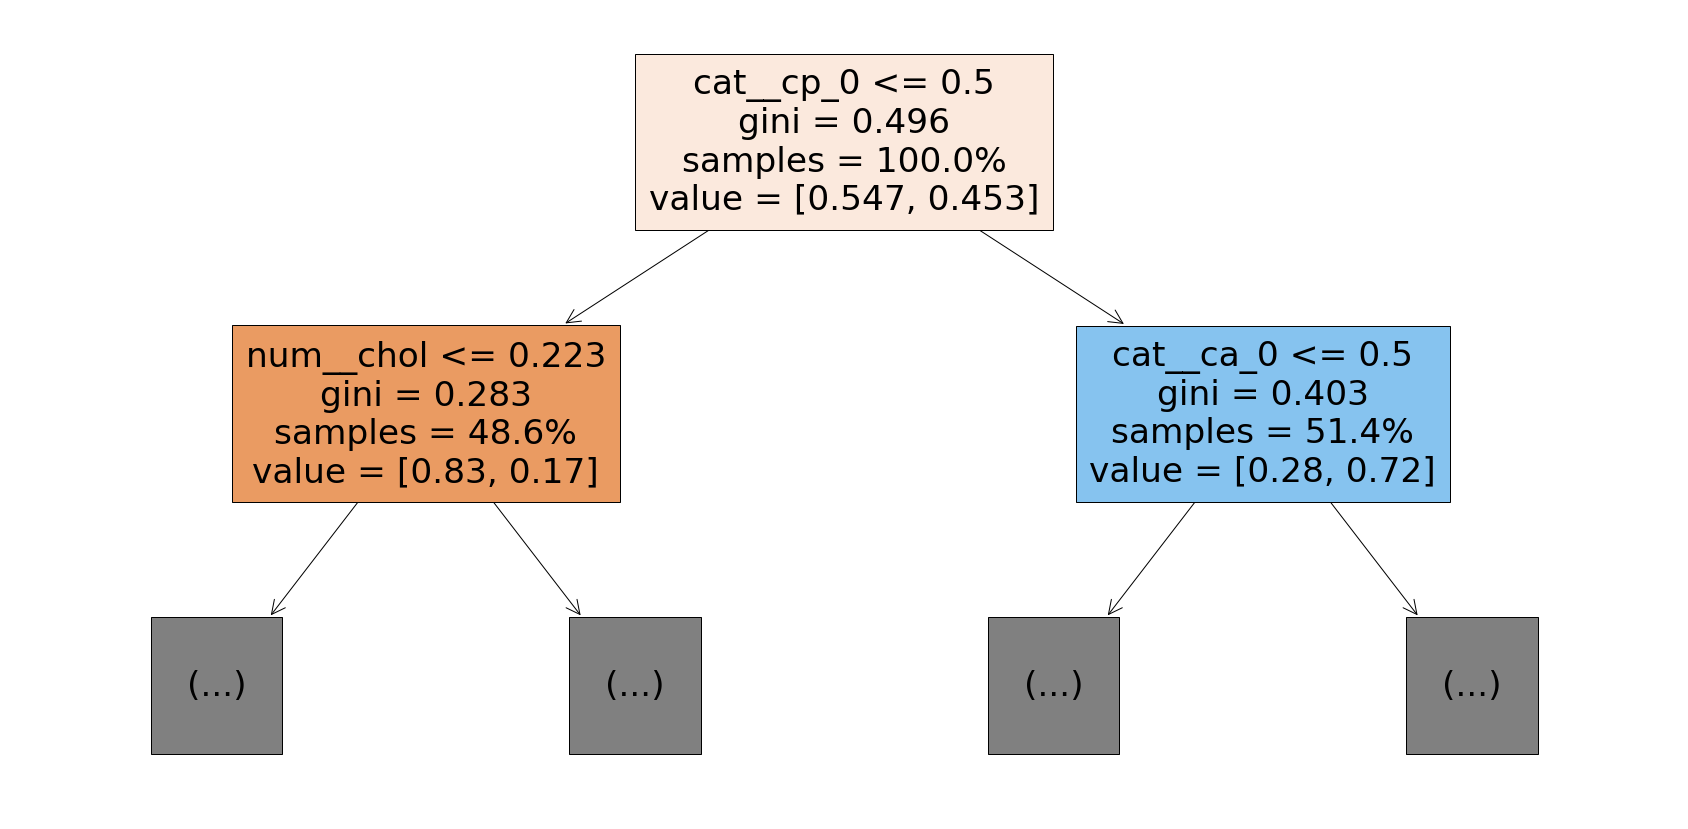

In [680]:
plt.figure(figsize = (30,15)) 
#Note that we have to pass the feature names into the plotting function to get the actual names
#We pass the column names through the pipeline in case any feature augmentation was made
#For example, a categorical feature will be split into multiple features with one hot encoding
#and this way assigns a name to each column based on the feature value and the original feature name
tree.plot_tree(clf,max_depth=1, proportion=True,feature_names=feature_names, filled=True)

**What is the gini index improvement of the first split?**

In [681]:
avg_gini = 0.283*0.486+0.403*0.514
gain = 0.496 - avg_gini
print("gini index imporvement is ", gain)

gini index imporvement is  0.15132


Response:

### [5 pts] Plot the importance of each feature for the Decision Tree

<AxesSubplot:>

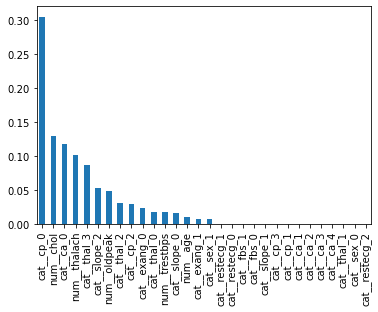

In [682]:
imp_pd = pd.Series(data = clf.feature_importances_ ,index = feature_names)
imp_pd= imp_pd.sort_values(ascending=False)
imp_pd.plot.bar()

**How many features have non-zero importance for the Decision Tree? If we remove the features with zero importance, will it change the decision tree for the same sampled dataset?** 

In [683]:
count = 0
non_zero = []
for i in range(len(imp_pd.values)):
    if imp_pd.values[i]!= 0:
        count+=1
        non_zero.append(imp_pd.index[i])
print("There are ",count,"features with non-zero importance." )
print("They are",non_zero)

There are  16 features with non-zero importance.
They are ['cat__cp_0', 'num__chol', 'cat__ca_0', 'num__thalach', 'cat__thal_3', 'cat__slope_2', 'num__oldpeak', 'cat__thal_2', 'cat__cp_2', 'cat__exang_0', 'cat__thal_0', 'num__trestbps', 'cat__slope_0', 'num__age', 'cat__exang_1', 'cat__sex_1']


Response: There are  16 features with non-zero importance.
They are ['cat__cp_0', 'num__chol', 'cat__ca_0', 'num__thalach', 'cat__thal_3', 'cat__slope_2', 'num__oldpeak', 'cat__thal_2', 'cat__cp_2', 'cat__exang_0', 'cat__thal_0', 'num__trestbps', 'cat__slope_0', 'num__age', 'cat__exang_1', 'cat__sex_1']

### [10 pts] Optimize Decision Tree

While the default Decision Tree performs fairly well on the data, lets see if we can improve performance by optimizing the parameters.

Run a GridSearchCV with 3-Fold Cross Validation for the Decision Tree. Find the best model parameters amongst the following:

- max_depth = [1,2,3,4,5,10,15]
- min_samples_split = [2,4,6,8]
- criterion = ["gini", "entropy"]

After using GridSearchCV, print the best model parameters and the best score.

In [684]:
from sklearn.model_selection import GridSearchCV

In [685]:
k = 3
kf = KFold(n_splits=k, random_state=None)

max_depth = [1,2,3,4,5,10,15]
min_samples_split = [2,4,6,8]
criterion = ["gini", "entropy"]

parameters = [{"max_depth": [1,2,3,4,5,10,15],
               "min_samples_split": [2,4,6,8],
               "criterion": ["gini", "entropy"]}]
    
clf = DecisionTreeClassifier(criterion = "gini")
grid = GridSearchCV(clf , parameters, cv = kf, scoring = "accuracy")
grid.fit(train,target)

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(),
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_depth': [1, 2, 3, 4, 5, 10, 15],
                          'min_samples_split': [2, 4, 6, 8]}],
             scoring='accuracy')

In [686]:
res= pd.DataFrame(grid.cv_results_)
res

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.001614      0.000500         0.000687    3.125881e-05   
1        0.000587      0.000149         0.000267    4.591565e-05   
2        0.000509      0.000048         0.000244    7.137530e-06   
3        0.000466      0.000006         0.000231    1.052828e-05   
4        0.000658      0.000109         0.000277    1.692641e-05   
5        0.000490      0.000017         0.000208    2.063235e-06   
6        0.000470      0.000001         0.000199    1.700793e-06   
7        0.000478      0.000004         0.000247    3.477389e-05   
8        0.000540      0.000003         0.000202    3.460493e-06   
9        0.000537      0.000006         0.000204    3.270962e-06   
10       0.000585      0.000007         0.000224    6.187665e-06   
11       0.000583      0.000005         0.000219    3.789781e-06   
12       0.000731      0.000094         0.000238    1.113358e-05   
13       0.000634      0.000020         0.000214    5.346581e-06   
14       0.000614      0.000036         0.000212    9.024282e-06   
15       0.000689      0.000089         0.000223    2.439182e-06   
16       0.000734      0.000089         0.000229    1.544189e-05   
17       0.000653      0.000010         0.000213    5.159007e-06   
18       0.000659      0.000027         0.000230    7.531914e-06   
19       0.000595      0.000018         0.000190    4.022614e-06   
20       0.000583      0.000022         0.000190    2.006780e-05   
21       0.000552      0.000036         0.000171    8.991328e-07   
22       0.000543      0.000028         0.000172    1.173403e-06   
23       0.000503      0.000016         0.000167    5.055124e-06   
24       0.000512      0.000030         0.000159    1.408263e-06   
25       0.000485      0.000025         0.000153    1.072147e-06   
26       0.000489      0.000029         0.000154    2.306083e-06   
27       0.000457      0.000024         0.000147    1.296163e-06   
28       0.000307      0.000002         0.000145    5.947204e-07   
29       0.000308      0.000003         0.000147    4.784240e-06   
30       0.000311      0.000012         0.000152    5.673271e-06   
31       0.000304      0.000003         0.000144    7.867412e-07   
32       0.000363      0.000003         0.000147    2.657295e-06   
33       0.000361      0.000002         0.000147    1.784161e-06   
34       0.000372      0.000014         0.000145    7.867412e-07   
35       0.000364      0.000006         0.000146    4.960533e-06   
36       0.000414      0.000003         0.000145    1.123916e-07   
37       0.000419      0.000004         0.000146    2.245020e-06   
38       0.000418      0.000003         0.000147    9.602742e-07   
39       0.000419      0.000004         0.000145    8.485379e-07   
40       0.000458      0.000003         0.000146    1.678364e-06   
41       0.000479      0.000015         0.000152    2.099648e-06   
42       0.000466      0.000009         0.000149    1.593426e-06   
43       0.000461      0.000002         0.000146    1.011524e-06   
44       0.000486      0.000009         0.000147    8.991328e-07   
45       0.000502      0.000011         0.000148    1.798266e-06   
46       0.000483      0.000008         0.000147    1.276523e-06   
47       0.000475      0.000011         0.000145    5.619580e-07   
48       0.000524      0.000039         0.000154    8.977971e-06   
49       0.000525      0.000028         0.000150    3.759663e-06   
50       0.000510      0.000035         0.000149    4.495664e-07   
51       0.000517      0.000053         0.000149    3.654023e-06   
52       0.000537      0.000032         0.000153    5.081294e-06   
53       0.000557      0.000064         0.000161    7.724010e-06   
54       0.000533      0.000029         0.000156    2.081521e-06   
55       0.000522      0.000023         0.000153    5.408827e-06   

   param_criterion param_max_depth param_min_samples_split  \
0             gini               1                       2   
1  

In [687]:
#Extract the columns that specify the score and the parameters for each row
res[["rank_test_score","param_criterion","param_max_depth","param_min_samples_split","mean_test_score"]]

rank_test_score param_criterion param_max_depth param_min_samples_split  \
0                14            gini               1                       2   
1                14            gini               1                       4   
2                14            gini               1                       6   
3                14            gini               1                       8   
4                35            gini               2                       2   
5                35            gini               2                       4   
6                35            gini               2                       6   
7                35            gini               2                       8   
8                29            gini               3                       2   
9                29            gini               3                       4   
10               32            gini               3                       6   
11               26            gini               3                       8   
12               31            gini               4                       2   
13               44            gini               4                       4   
14               52            gini               4                       6   
15               42            gini               4                       8   
16               52            gini               5                       2   
17               40            gini               5                       4   
18               44            gini               5                       6   
19               41            gini               5                       8   
20               54            gini              10                       2   
21               44            gini              10                       4   
22               55            gini              10                       6   
23               28            gini              10                       8   
24                3            gini              15                       2   
25               34            gini              15                       4   
26               56            gini              15                       6   
27               47            gini              15                       8   
28               14         entropy               1                       2   
29               14         entropy               1                       4   
30               14         entropy               1                       6   
31               14         entropy               1                       8   
32               48         entropy               2                       2   
33               48         entropy               2                       4   
34               48         entropy               2                       6   
35               48         entropy               2                       8   
36               22         entropy               3                       2   
37               22         entropy               3                       4   
38               22         entropy               3                       6   
39               22         entropy               3                       8   
40                4         entropy               4                       2   
41                4         entropy               4                       4   
42                4         entropy               4                       6   
43                1         entropy               4                       8   
44                7         entropy               5                       2   
45                7         entropy               5                       4   
46                7         entropy               5                       6   
47               12         entropy               5                       8   
48               33         entropy              10                       2   
49               11         entropy              10   

**Using the best model you have, report the test accuracy and print out the confusion matrix**

In [688]:
clf_best = DecisionTreeClassifier(criterion = "entropy", max_depth = 10,min_samples_split = 6)
clf_best.fit(train, target)
predicted = clf_best.predict(test)

Accuracy:    0.721311
Confusion Matrix: 
 [[54 12]
 [22 34]]


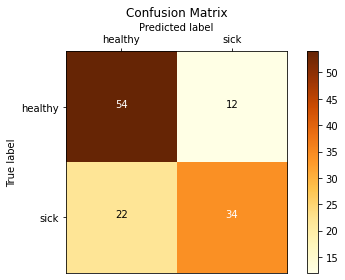

In [689]:
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))
print("Confusion Matrix: \n", metrics.confusion_matrix(target_test,predicted))
draw_confusion_matrix(target_test, predicted, ['healthy', 'sick'])

[Text(0.5, 0.8333333333333334, 'cat__cp_0 <= 0.5\nentropy = 0.994\nsamples = 100.0%\nvalue = [0.547, 0.453]'),
 Text(0.25, 0.5, 'num__chol <= 0.223\nentropy = 0.659\nsamples = 48.6%\nvalue = [0.83, 0.17]'),
 Text(0.125, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.375, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.75, 0.5, 'cat__ca_0 <= 0.5\nentropy = 0.855\nsamples = 51.4%\nvalue = [0.28, 0.72]'),
 Text(0.625, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.875, 0.16666666666666666, '\n  (...)  \n')]

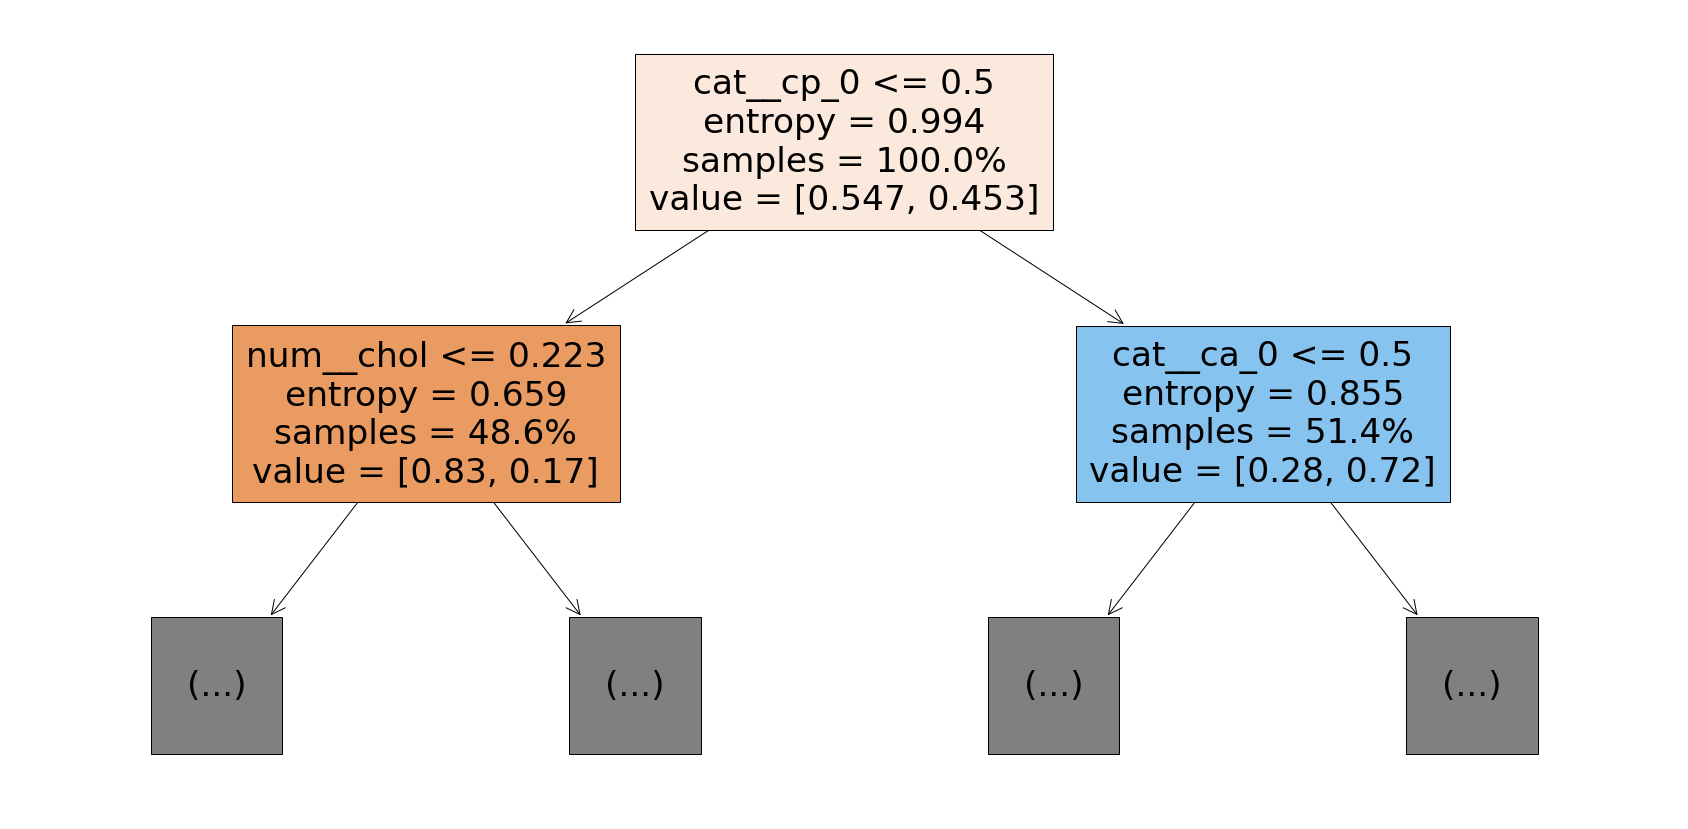

In [690]:
plt.figure(figsize = (30,15)) 
#Note that we have to pass the feature names into the plotting function to get the actual names
#We pass the column names through the pipeline in case any feature augmentation was made
#For example, a categorical feature will be split into multiple features with one hot encoding
#and this way assigns a name to each column based on the feature value and the original feature name
tree.plot_tree(clf_best,max_depth=1, proportion=True,feature_names=feature_names, filled=True)

## (20 pts) Multi-Layer Perceptron

### [5 pts] Applying a Multi-Layer Perceptron
Apply the MLP on the **train data** with hidden_layer_sizes=(100,100) and max_iter = 800. **Report the accuracy and print the confusion matrix**. Make sure to set random_state=0. 

In [691]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(100,100), max_iter = 800, random_state = 0)
clf.fit(train, target)
predicted = clf.predict(test)

Accuracy:    0.819672
Confusion Matrix: 
 [[63  3]
 [19 37]]


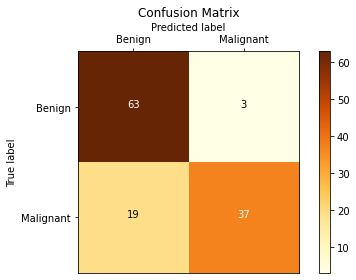

In [692]:
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))
print("Confusion Matrix: \n", metrics.confusion_matrix(target_test,predicted))
draw_confusion_matrix(target_test, predicted, ['Benign', 'Malignant'])

### [10 pts] Speedtest between Decision Tree and MLP

Let us compare the training times and prediction times of a Decision Tree and an MLP. **Time how long it takes for a Decision Tree and an MLP to perform a .fit operation (i.e. training the model). Then, time how long it takes for a Decision Tree and an MLP to perform a .predict operation (i.e. predicting the testing data). Print out the timings and specify which model was quicker for each operation.** We recommend using the [time](https://docs.python.org/3/library/time.html) python module to time your code. 
An example of the time module was shown in project 2. Use the default Decision Tree Classifier and the MLP with the previously mentioned parameters.

In [693]:
#Time for train operation: Decison tree
import time

start_time = time.time()
clf = DecisionTreeClassifier(criterion="gini", random_state = 0)
clf.fit(train, target)
print("fitting time--- %s seconds ---" % (time.time() - start_time))

fitting time--- 0.002093076705932617 seconds ---


In [694]:
start_time = time.time()
predicted = clf.predict(test)
print("predicting time--- %s seconds ---" % (time.time() - start_time))

predicting time--- 0.0004069805145263672 seconds ---


In [695]:
#Time for train operation: MLP

start_time = time.time()
clf = MLPClassifier(hidden_layer_sizes=(100,100), max_iter = 800, random_state = 0)
clf.fit(train, target)
print("fitting time--- %s seconds ---" % (time.time() - start_time))

fitting time--- 0.6231658458709717 seconds ---


In [696]:
start_time = time.time()
predicted = clf.predict(test)
print("predicting time--- %s seconds ---" % (time.time() - start_time))

predicting time--- 0.0012581348419189453 seconds ---


### [5 pts] Compare and contrast Decision Trees and MLPs.

**Describe at least one advantage and disadvantage of using an MLP over a Decision Tree.**

#### As shown in the previous part, the predicting time is close between these two. However, the fitting time for MLP is much longer than decision tree. (Since there are more parameters to train)

#### As shown in the above, MLP does have a better accuarcy than decison trees, since more features can be captured.

## (35 pts) PCA

### [5 pts] Transform the train data using PCA

Train a PCA model to project the train data on the top 10 components. **Print out the 10 principal components**. Look at the documentation of [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) for reference.

In [697]:
#Perform PCA
from sklearn.decomposition import PCA
 
pca = PCA(10)
pca_pipe = Pipeline([("scaler",StandardScaler()), #Scikit learn PCA does not standardize so we need to add
               ("pca",pca)])
pca_pipe.fit(train)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=10))])

In [698]:
train.shape

(181, 30)

In [699]:
pca.components_.shape

(10, 30)

In [700]:
print(pca.components_)

[[ 0.18611809  0.14723377  0.0827966  -0.26958547  0.28724158 -0.08876141
   0.08876141  0.29373271 -0.18880161 -0.18588046  0.00547491 -0.03616204
   0.03616204  0.17165538 -0.18229389  0.04263397 -0.29674427  0.29674427
   0.12038936  0.23640547 -0.29624895 -0.19017656  0.06708592  0.13205351
   0.14006446 -0.08106023 -0.00461948  0.08832725 -0.26014306  0.21954194]
 [ 0.17782264  0.12934087  0.21781761  0.00085997 -0.00819057  0.47896852
  -0.47896852  0.01761698 -0.04673436  0.02638517 -0.01520276 -0.07185905
   0.07185905  0.32618016 -0.35610124  0.11900946  0.08021001 -0.08021001
  -0.05087735  0.09295655 -0.06752443  0.04033609 -0.06904782  0.0610647
   0.03216393 -0.13364728  0.02210197 -0.01976779  0.25112614 -0.25016493]
 [ 0.1113784   0.20923116 -0.08340017  0.07921133 -0.03404349 -0.2018614
   0.2018614  -0.17797524 -0.05583133  0.16476042  0.1340265  -0.5511467
   0.5511467   0.16551362 -0.14622474 -0.07456177  0.10682938 -0.10682938
   0.02514107 -0.12564882  0.11302289 -

### [5 pts] Percentage of variance explained by top 10 principal components

Using PCA's "explained_variance_ratio_", print the percentage of variance explained by the top 10 principal components.

In [701]:
pca.explained_variance_ratio_

array([0.17626116, 0.08915634, 0.07963692, 0.06307261, 0.05597995,
       0.05167126, 0.04939192, 0.04876524, 0.0428602 , 0.04058251])

### [5 pts] Transform the train and test data into train_pca and test_pca using PCA

Note: Use fit_transform for train and transform for test

In [702]:
#pca = PCA(n_components = 0.9) #
train_new = pca.fit_transform(train)
test_new = pca.transform(test)

### [5 pts] PCA+Decision Tree

Train the default Decision Tree Classifier using train_pca. **Report the accuracy using test_pca and print the confusion matrix**.

Accuracy with PCA
Accuracy:    0.762295
Confusion Matrix: 
 [[53 13]
 [16 40]]


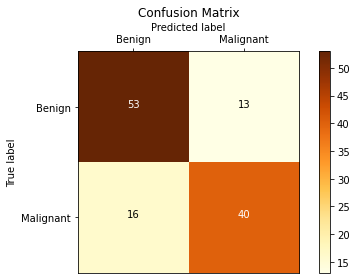

In [703]:
#With PCA

clf_pca = DecisionTreeClassifier(random_state=0)
clf_pca.fit(train_new, target)
predicted = clf_pca.predict(test_new)

print("Accuracy with PCA")
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))
print("Confusion Matrix: \n", metrics.confusion_matrix(target_test,predicted))
draw_confusion_matrix(target_test, predicted, ['Benign', 'Malignant'])

**Does the model perform better with or without PCA?**

Response: With PCA is much better.

### [5 pts] PCA+MLP

Train the MLP classifier with the same parameters as before using train_pca. **Report the accuracy using test_pca and print the confusion matrix**.

In [704]:
pca = PCA()
pca_pipe = Pipeline([("scaler",StandardScaler()), #Scikit learn PCA does not standardize so we need to add
               ("pca",pca)])
pca_pipe.fit(train)

train_new = pca.fit_transform(train)
test_new = pca.transform(test)

clf_pca = MLPClassifier(hidden_layer_sizes=(100,100), max_iter = 800, random_state = 0)
clf_pca.fit(train_new, target)
predicted = clf.predict(test_new)

Accuracy with PCA
Accuracy:    0.500000
Confusion Matrix: 
 [[36 30]
 [31 25]]


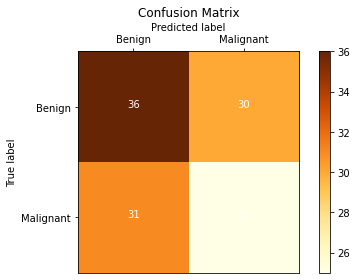

In [705]:
print("Accuracy with PCA")
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))
print("Confusion Matrix: \n", metrics.confusion_matrix(target_test,predicted))
draw_confusion_matrix(target_test, predicted, ['Benign', 'Malignant'])

**Does the model perform better with or without PCA?**

Response: No, it performed much worse than without PCA.

### [10 pts] Pros and Cons of PCA

**In your own words, provide at least two pros and at least two cons for using PCA**

#### Response: 
#### Disadvantage: Information loss. This might affect the classifier's performance(as shown in the previous part MLP+PCA had a worse performance!!)

#### Disadvantage: Data become less interpretable. With PCA, we are not able to print out the importnt features like the previous part when we use the decision trees.

#### Advantages: Removes correlated feautures. PCA helps us to remove the correlation efficiently so we do not have to do it ourselves. 

#### Advantages: Improve some algorithm efficiency. For example, combined with pca, the decision tree algortihm had a better performance in this task.

## (20 pts) K-Means Clustering

### [5 pts] Apply K-means to the train data and print out the Inertia score

Use n_cluster = 5 and random_state = 0.

In [706]:
from sklearn.cluster import KMeans

n_clusters = 5 #We know there are 10 subjects
km = KMeans(n_clusters  = n_clusters,random_state=0)
# pipe= Pipeline([("scaler",StandardScaler()), #First standardize
#                ("pca",PCA()), #Transform using pca
#          ("kmeans", km )]) #Then apply k means

In [707]:
pre = km.fit(train)
clusters = pre.fit_predict(train)
print(pre.inertia_)
print(clusters)

491.0665663612592
[0 2 3 4 2 3 1 3 1 1 3 4 4 3 0 3 1 0 1 3 2 3 0 4 3 4 2 2 3 1 4 0 1 1 4 2 4
 4 4 0 1 0 3 1 2 2 3 1 0 0 3 1 1 1 4 0 3 0 2 1 2 4 0 3 2 2 4 2 0 0 2 0 0 0
 1 0 2 1 3 1 2 4 0 4 2 3 3 1 1 3 2 4 0 1 1 3 3 2 3 2 4 2 3 0 0 4 1 2 2 1 4
 2 1 2 3 3 1 4 3 0 0 3 4 2 4 1 0 3 2 3 3 0 4 4 2 1 1 0 1 2 1 1 2 3 0 3 1 0
 1 3 0 1 2 1 2 2 2 3 0 2 3 4 3 2 1 1 2 2 2 0 1 1 1 3 1 0 2 4 3 3 0]


### [10 pts] Find the optimal cluster size using the elbow method. 

Use the elbow method to find the best cluster size or range of best cluster sizes for the train data. Check the cluster sizes from 2 to 20. Make sure to plot the Inertia and state where you think the elbow starts. Make sure to use random_state = 0.

In [708]:
ks = list(range(2,20))
inertia = []
for k in ks:
    kmeans = KMeans(n_clusters=k , random_state=0)
    kmeans.fit(train)
    # inertia method returns wcss for that model
    inertia.append(kmeans.inertia_)
    print(f"Inertia for K = {k}: {kmeans.inertia_}")

Inertia for K = 2: 619.2596852490838
Inertia for K = 3: 562.2941749488493
Inertia for K = 4: 515.3501104402982
Inertia for K = 5: 491.0665663612592
Inertia for K = 6: 458.3449062857246
Inertia for K = 7: 436.46731311592123
Inertia for K = 8: 427.64243132453544
Inertia for K = 9: 409.3453854307658
Inertia for K = 10: 393.8362013824142
Inertia for K = 11: 375.627142914177
Inertia for K = 12: 366.872574191804
Inertia for K = 13: 356.0704428612708
Inertia for K = 14: 353.0506627827143
Inertia for K = 15: 342.96648926542787
Inertia for K = 16: 335.8288846772815
Inertia for K = 17: 325.33654094415067
Inertia for K = 18: 310.3448076066395
Inertia for K = 19: 306.7095752890683


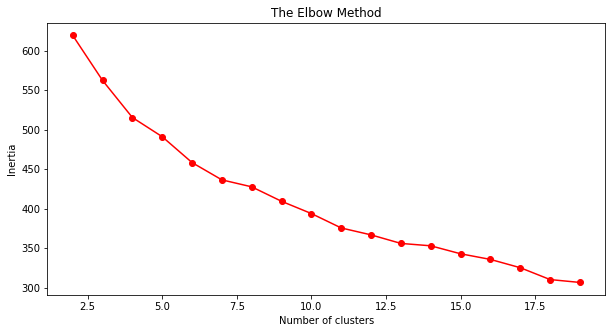

In [709]:
plt.figure(figsize=(10,5))
plt.plot(ks, inertia,marker='o',color='red')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

#### The elbow starts at around 5~10

### [5 pts] Find the optimal cluster size for the train_pca data
 
Repeat the same experiment but use train_pca instead of train. 

In [710]:
pca = PCA(10)
train_new = pca.fit_transform(train)
test_new = pca.transform(test)

In [711]:
ks = list(range(2,20))
inertia = []
for k in ks:
    kmeans = KMeans(n_clusters=k , random_state=0)
    kmeans.fit(train_new)
    # inertia method returns wcss for that model
    inertia.append(kmeans.inertia_)
    print(f"Inertia for K = {k}: {kmeans.inertia_}")

Inertia for K = 2: 526.8986473659899
Inertia for K = 3: 469.48656326630123
Inertia for K = 4: 423.2161135203967
Inertia for K = 5: 403.58791237506733
Inertia for K = 6: 371.0784572148915
Inertia for K = 7: 350.3642628743978
Inertia for K = 8: 330.0476150629753
Inertia for K = 9: 314.6918920164625
Inertia for K = 10: 298.74474399366363
Inertia for K = 11: 288.50442948032435
Inertia for K = 12: 277.3547969513997
Inertia for K = 13: 266.20679282269043
Inertia for K = 14: 258.12394695638227
Inertia for K = 15: 250.34211491204923
Inertia for K = 16: 234.46445989492167
Inertia for K = 17: 231.17570259556672
Inertia for K = 18: 221.7837342794704
Inertia for K = 19: 220.04830474526793


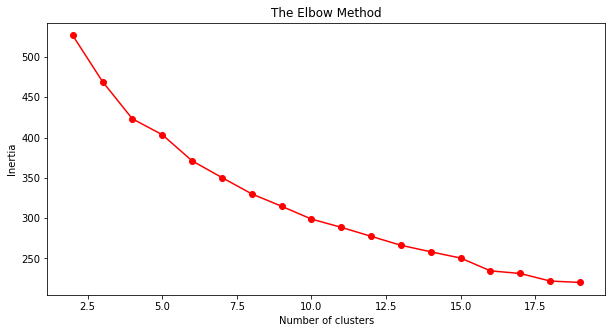

In [712]:
plt.figure(figsize=(10,5))
plt.plot(ks, inertia,marker='o',color='red')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

**Notice that the inertia is much smaller for every cluster size when using PCA features. Why do you think this is happening? Hint: Think about what Inertia is calculating and consider the number of features that PCA outputs.**

Response: Inertia is the sum of the distance square between each data point and its centroid. Since PCA reduces correlated features, the distance would become smaller, the intertia would also become samller.

# (100 pts) Putting it all together

Through all the homeworks and projects, you have learned how to apply many different models to perform a supervised learning task. We are now asking you to take everything that you learned to create a model that can predict whether a hotel reservation will be canceled or not.


**Context**

Hotels see millions of people every year and always wants to keep rooms occupied and payed for. Cancellations make the business loss money since it may make it difficult to reserve to another customer on such short notice. As such, it is useful for a hotel to know whether a reservation is likely to cancel or not. The following dataset will provide a variety of information about a booking that you will use to predict whether that booking will cancel or not. 


Property Management System - PMS

**Attribute Information**

(C) is for Categorical 

(N) is for Numeric

    1) is_canceled (C) : Value indicating if the booking was canceled (1) or not (0).
    2) hotel (C) : The datasets contains the booking information of two hotel. One of the hotels is a resort hotel and the other is a city hotel.
    3) arrival_date_month (C): Month of arrival date with 12 categories: “January” to “December”
    4) stays_in_weekend_nights (N): Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel
    5) stays_in_week_nights (N): Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel BO and BL/Calculated by counting the number of week nights
    6) adults (N): Number of adults
    7) children (N): Number of children
    8) babies (N): Number of babies
    9) meal (C): Type of meal
    10) country (C): Country of origin.
    11) previous_cancellations (N): Number of previous bookings that were canceled by the customer prior to the current booking
    12) previous_bookings_not_canceled (N) : Number of previous bookings not canceled by the customer prior to the current booking
    13) reserved_room_type (C): Code of room type reserved. Code is presented instead of designation for anonymity reasons
    14) booking_changes (N) : Number of changes/amendments made to the booking from the moment the booking was entered on the PMS until the moment of check-in or cancellation
    15) deposit_type (C) : No Deposit – no deposit was made; Non Refund – a deposit was made in the value of the total stay cost; Refundable – a deposit was made with a value under the total cost of stay
    16) days_in_waiting_list (N): Number of days the booking was in the waiting list before it was confirmed to the customer
    17) customer_type (C): Group – when the booking is associated to a group; Transient – when the booking is not part of a group or contract, and is not associated to other transient booking; Transient-party – when the booking is transient, but is associated to at least other transient booking
    18) adr (N): Average Daily Rate (Calculated by dividing the sum of all lodging transactions by the total number of staying nights)
    19) required_car_parking_spaces (N): Number of car parking spaces required by the customer
    20) total_of_special_requests (N): Number of special requests made by the customer (e.g. twin bed or high floor)
    21) name (C): Name of the Guest (Not Real)
    22) email (C): Email (Not Real)
    23) phone-number (C): Phone number (not real)

This dataset is quite large with 86989 samples. This makes it difficult to just brute force running a lot of models. As such, you have to be thoughtful when designing your models.

The file name for the training data is "hotel_booking.csv".

**Challenge**

This project is about being able to predict whether a reservation is likely to cancel based on the
input parameters available to us. We will ask you to perform some specific instructions to lead you in the right direction but you are given free reign on which models to use and the preprocessing steps you make. We will ask you to **write out a description of what models you choose and why you choose them**.

## (50 pts) Preprocessing


**Preprocessing:**
For the dataset, the following are mandatory pre-processing steps for your data:

- Use One-Hot Encoding on all categorical features (specify whether you keep the extra feature or not for features with multiple values)
- Determine which fields need to be dropped
- Handle missing values (Specify your strategy)
- Rescale the real valued features using any strategy you choose (StandardScaler, MinMaxScaler, Normalizer, etc)
- Augment at least one feature
- Implement a train-test split with 20% of the data going to the test data. Make sure that the test and train data are balanced in terms of the desired class.


After writing your preprocessing code, write out a description of what you did for each step and provide a justification for your choices. All descriptions should be written in the markdown cells of the jupyter notebook. Make sure your writing is clear and professional.  

We highly recommend reading through the [scikit-learn documentation](https://scikit-learn.org/stable/data_transforms.html) to make this part easier.

In [6]:
#Preprocess Data

#Load Data
data = pd.read_csv('datasets/hotel_booking.csv')

In [7]:
data.head(5)

is_canceled         hotel  lead_time arrival_date_month  \
0            0  Resort Hotel          4           February   
1            1    City Hotel        172               June   
2            0    City Hotel          4           November   
3            1    City Hotel         68          September   
4            1    City Hotel        149               July   

   stays_in_weekend_nights  stays_in_week_nights  adults  children  babies  \
0                        1                     2       2       0.0       0   
1                        0                     2       1       0.0       0   
2                        2                     1       1       0.0       0   
3                        0                     2       2       0.0       0   
4                        2                     4       3       0.0       0   

  meal  ... booking_changes  deposit_type  days_in_waiting_list  \
0   FB  ...               0    No Deposit                     0   
1   BB  ...               0    No Deposit                     0   
2   BB  ...               0    No Deposit                     0   
3   HB  ...               0    No Deposit                     0   
4   BB  ...               0    No Deposit                     0   

     customer_type    adr required_car_parking_spaces  \
0        Transient   75.0                           0   
1  Transient-Party   95.0                           0   
2        Transient   65.0                           0   
3  Transient-Party    0.0                           0   
4        Transient  167.7                           0   

   total_of_special_requests             name                         email  \
0                          1      Linda Moore                LMoore@att.com   
1                          0   Madison Greene  Greene_Madison56@verizon.com   
2                          0  Alicia Richards   Richards.Alicia@comcast.net   
3                          0    Gregory Smith      GregorySmith@outlook.com   
4                          0  Rachel Martinez          Rachel.M@outlook.com   

   phone-number  
0  217-602-3707  
1  791-162-2669  
2  442-385-2754  
3  670-687-2703  
4  692-194-2274  

[5 rows x 24 columns]

In [8]:
data.isnull().sum()

is_canceled                       0
hotel                             0
lead_time                         0
arrival_date_month                0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          3
babies                            0
meal                              0
country                           0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
booking_changes                   0
deposit_type                      0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces       0
total_of_special_requests         0
name                              0
email                             0
phone-number                      0
dtype: int64

#### For Children data, we have to do some imputation.

#### The strategy is to use the mean of the dataset to replace the null values.

In [9]:
data['children'].fillna(data['children'].mean(), inplace = True)

In [10]:
#Transform target feature into numerical
le = LabelEncoder() 
data['is_canceled'] = le.fit_transform(data['is_canceled'])
#Split target and data
housing_target= data['is_canceled']
housing_features = data.drop(['is_canceled'],axis = 1)

#### Drop redundant features.

In [11]:
housing_features = housing_features.drop(['name'],axis = 1).drop(['phone-number'],axis = 1).drop(['email'],axis = 1)

#### Prepare pipelines

In [12]:
#cat_list = ['hotel','arrival_date_month','meal','country','reserved_room_type','deposit_type','customer_type','name','email','phone-number']
cat_list = ['hotel','arrival_date_month','meal','country','reserved_room_type','deposit_type','customer_type']
housing_features_num = housing_features
for features in cat_list:
    housing_features_num = housing_features_num.drop(features, axis=1)

In [13]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.base import BaseEstimator, TransformerMixin

previous_bookings_not_canceled,previous_cancellations,stays_in_week_nights, stays_in_weekend_nights = 1,2,6,7

class AugmentFeatures(BaseEstimator, TransformerMixin):
    def __init__(self,add_att = True): 
        self.add_att = add_att
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self,X):
        if self.add_att:
            no_cancel = X[:,previous_bookings_not_canceled]+0.0001
            cancel = X[:,previous_cancellations]
            night_work = X[:,stays_in_week_nights]
            night_end = X[:,stays_in_weekend_nights]
            total_nights = night_work+night_end
            cancel_rate = cancel/(no_cancel+cancel)
            return np.c_[X, cancel_rate, total_nights]
        else:
            return np.c_[X]


#### We rescaled the numerical data in the pipelines!

In [14]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")), #Imputes using median
        ('attribs_adder', AugmentFeatures(add_att=True)), #
        ('std_scaler', StandardScaler()),
    ])

housing_features_num_tr = num_pipeline.fit_transform(housing_features_num)
print("Example Output of Pipeline for numerical output")
print(housing_features_num_tr[0].shape)

Example Output of Pipeline for numerical output
(15,)


In [15]:
num_list = list(housing_features_num)

In [16]:
print(cat_list)

['hotel', 'arrival_date_month', 'meal', 'country', 'reserved_room_type', 'deposit_type', 'customer_type']


In [17]:
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_list),
        ("cat", OneHotEncoder(categories='auto'), cat_list),
    ])

housing_prepared = full_pipeline.fit_transform(housing_features)
print("Example Output of full Pipeline")
(housing_prepared[19])
#size 56

Example Output of full Pipeline


array([ 1.86244033, -0.89381571, -0.23488192,  0.26145001, -0.24154689,
       -0.08269648,  1.00697024, -0.10048293, -0.33937292, -0.14555724,
       -0.68217058, -0.26246159, -0.66396821,  0.8744963 ,  0.3443857 ,
        1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  1.        ,  1.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  1.        ,  1.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.        ])

In [18]:
housing_features.shape

(78290, 20)

In [19]:
from sklearn.model_selection import train_test_split
train_raw, test_raw, target, target_test = train_test_split(housing_features, housing_target, test_size=0.2, random_state = 1)
train = full_pipeline.fit_transform(train_raw)
test = full_pipeline.transform(test_raw)

In [20]:
##Why do I have to set random state = 1 in order to obatin a normal shape? (Or it would get (0)56,55 or (default)55,56)

In [21]:
train.shape

(62632, 56)

In [22]:
test.shape

(15658, 56)

## (50 pts) Try out a few models
Now that you have pre-processed your data, you are ready to try out different models. 

For this part of the project, we want you to experiment with all the different models demonstrated in the course to determine which one performs best on the dataset.

You must perform classification using at least 3 of the following models:
- Logistic Regression
- K-nearest neighbors
- SVM
- Decision Tree
- Multi-Layer Perceptron

Due to the size of the dataset, be careful which models you use and look at their documentation to see how you should tackle this size issue for each model.

For full credit, you must perform some hyperparameter optimization on your models of choice. You may find the following scikit-learn library on [hyperparameter optimization](https://scikit-learn.org/stable/modules/grid_search.html#grid-search) useful.

For each model chosen, write a description of which models were chosen, which parameters you optimized, and which parameters you choose for your best model. 
While the previous part of the project asked you to pre-process the data in a specific manner, you may alter pre-processing step as you wish to adjust for your chosen classification models.


### 1.Logistic Regression.

In [817]:
#log_reg = LogisticRegression(penalty = "l2",max_iter = 1000, solver = "lbfgs", C=10**30) 
#C is choosen to be high to remove regularization
#We could have chosen penalty = "none" since lbfgs supports it but this option is not possible for all solvers.
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(penalty = "l2",max_iter = 1000, solver = 'liblinear', C=10**30) 

log_reg.fit(train, target)
testing_result = log_reg.predict(test)
predicted = log_reg.predict(test)

print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))

Accuracy:    0.809618


#### For logistic regression, no matter we change the penalty to l1, l2 or none, and the solver, the testing accuarcy don't exceed 0.81.

In [732]:
#Cross Validation
parameters = [
    {"penalty": ["l2"],
    "C": [0.1,1,10],
    "solver": ["lbfgs","liblinear"]},#These solvers support penalty = "l2"
    {"penalty": ["none"],
    "C": [1], #Specified to prevent error message
    "solver": ["lbfgs","newton-cg"]},#These solvers support penalty = "none"
]

#instantiate model


#Implementing cross validation

k = 3
kf = KFold(n_splits=k, random_state=None)

log_reg = LogisticRegression(penalty = "none",max_iter = 1000, solver = "lbfgs") #will change parameters during CV
grid = GridSearchCV(log_reg , parameters, cv = kf, scoring = "accuracy")
grid.fit(train,target)

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             estimator=LogisticRegression(max_iter=1000, penalty='none'),
             param_grid=[{'C': [1000000000000000000000000000000,
                                10000000000000000000000000000000,
                                100000000000000000000000000000000],
                          'penalty': ['l2'], 'solver': ['lbfgs', 'liblinear']},
                         {'C': [1], 'penalty': ['none'],
                          'solver': ['lbfgs', 'newton-cg']}],
             scoring='accuracy')

In [733]:
res= pd.DataFrame(grid.cv_results_)
res

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.670841      0.110570         0.001829        0.000174   
1       0.494936      0.109673         0.001911        0.000337   
2       0.758404      0.157479         0.003201        0.001121   
3       0.549312      0.192833         0.002214        0.000062   
4       1.035876      0.250402         0.004021        0.001415   
5       0.571976      0.191742         0.002461        0.000570   
6       0.685953      0.139230         0.001915        0.000283   
7       1.234212      0.171821         0.001642        0.000033   

                             param_C param_penalty param_solver  \
0    1000000000000000000000000000000            l2        lbfgs   
1    1000000000000000000000000000000            l2    liblinear   
2   10000000000000000000000000000000            l2        lbfgs   
3   10000000000000000000000000000000            l2    liblinear   
4  100000000000000000000000000000000            l2        lbfgs   
5  100000000000000000000000000000000            l2    liblinear   
6                                  1          none        lbfgs   
7                                  1          none    newton-cg   

                                              params  split0_test_score  \
0  {'C': 1000000000000000000000000000000, 'penalt...           0.805106   
1  {'C': 1000000000000000000000000000000, 'penalt...           0.805106   
2  {'C': 10000000000000000000000000000000, 'penal...           0.805106   
3  {'C': 10000000000000000000000000000000, 'penal...           0.805106   
4  {'C': 100000000000000000000000000000000, 'pena...           0.805106   
5  {'C': 100000000000000000000000000000000, 'pena...           0.805106   
6     {'C': 1, 'penalty': 'none', 'solver': 'lbfgs'}           0.805106   
7  {'C': 1, 'penalty': 'none', 'solver': 'newton-...           0.805106   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0           0.810509           0.810461         0.808692        0.002536   
1           0.810509           0.810461         0.808692        0.002536   
2           0.810509           0.810461         0.808692        0.002536   
3           0.810509           0.810461         0.808692        0.002536   
4           0.810509           0.810461         0.808692        0.002536   
5           0.810509           0.810461         0.808692        0.002536   
6           0.810509           0.810461         0.808692        0.002536   
7           0.810509           0.810461         0.808692        0.002536   

   rank_test_score  
0                1  
1                1  
2                1  
3                1  
4                1  
5                1  
6                1  
7                1

#### Cross Validation doesn't give us hope to tune the parameters.

### 2. SVC

####  SVC has a long running time. We can use smaller dataset to select the parameters.

In [734]:
from sklearn.svm import SVC 

In [760]:
 #Note that there is no fit calls
train_raw, test_raw, target, target_test = train_test_split(housing_features, housing_target, test_size=0.2, random_state = 1)

In [761]:
train = full_pipeline.fit_transform(train_raw)
test = full_pipeline.transform(test_raw)

Accuracy:    0.850875


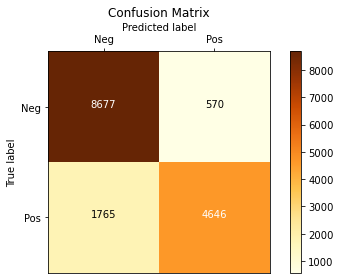

In [762]:
svm = SVC()
svm.fit(train, target)
predicted = svm.predict(test)
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))
draw_confusion_matrix(target_test, predicted, ['Neg', 'Pos'])

In [778]:
parameters = [{"kernel": ["linear","rbf"],
     "C": [0.0001,0.1,10]}
             ]

k = 3
kf = KFold(n_splits=k, random_state=None)
svm = SVC()
grid = GridSearchCV(svm , parameters, cv = kf, scoring = "accuracy")
grid.fit(train,target)

KeyboardInterrupt: 

#### Running time is too long!!

Accuracy:    0.590561


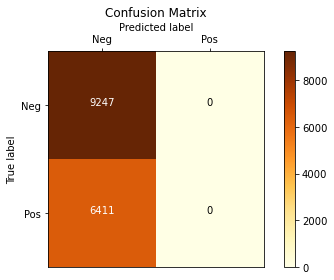

In [819]:
svm = SVC(C = 100)
svm.fit(train, target)
predicted = svm.predict(test)
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))
draw_confusion_matrix(target_test, predicted, ['Neg', 'Pos'])

#### For SVC We get a ~0.85 training acc, and a ~0.76 accuracy in Kaggle testing.

### 3. MLP

In [783]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(100,100), max_iter = 400,verbose=True)
clf.fit(train, target)
predicted = clf.predict(test)

Iteration 1, loss = 0.38555768
Iteration 2, loss = 0.33867235
Iteration 3, loss = 0.32579949
Iteration 4, loss = 0.31798646
Iteration 5, loss = 0.31211070
Iteration 6, loss = 0.30540542
Iteration 7, loss = 0.30066770
Iteration 8, loss = 0.29582335
Iteration 9, loss = 0.29213468
Iteration 10, loss = 0.28884020
Iteration 11, loss = 0.28700469
Iteration 12, loss = 0.28306730
Iteration 13, loss = 0.28015260
Iteration 14, loss = 0.27801146
Iteration 15, loss = 0.27470597
Iteration 16, loss = 0.27295246
Iteration 17, loss = 0.27043274
Iteration 18, loss = 0.26861283
Iteration 19, loss = 0.26745370
Iteration 20, loss = 0.26400982
Iteration 21, loss = 0.26301540
Iteration 22, loss = 0.26192226
Iteration 23, loss = 0.25977743
Iteration 24, loss = 0.25670720
Iteration 25, loss = 0.25642191
Iteration 26, loss = 0.25407929
Iteration 27, loss = 0.25268377
Iteration 28, loss = 0.25075285
Iteration 29, loss = 0.24979081
Iteration 30, loss = 0.24826870
Iteration 31, loss = 0.24605886
Iteration 32, los

Accuracy:    0.851641
Confusion Matrix: 
 [[7995 1252]
 [1071 5340]]


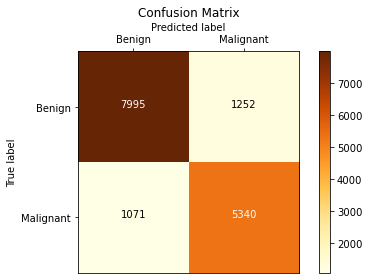

In [784]:
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))
print("Confusion Matrix: \n", metrics.confusion_matrix(target_test,predicted))
draw_confusion_matrix(target_test, predicted, ['Benign', 'Malignant'])

#### Tuning the parameters cannot make our training acc exceed 0.86, but our testing acc started to decrease (even to 0.5!!) 
#### This suggests overfitting is starting. We should look for another way. (Best = 0.7)

### 4. KNN

In [788]:
from sklearn.neighbors import KNeighborsClassifier

In [791]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(train, target)
predicted = knn.predict(test)

In [792]:
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))

Accuracy:    0.838677


In [793]:
from sklearn.model_selection import GridSearchCV
parameters = [{"n_neighbors": [1,3,5,7],
     "metric": ["euclidean","manhattan"]}]

k = 3
kf = KFold(n_splits=k, random_state=None)


knn = KNeighborsClassifier(n_neighbors=3) #will change parameters during CV
grid = GridSearchCV(knn , parameters, cv = kf, scoring = "accuracy")
grid.fit(train,target)

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             estimator=KNeighborsClassifier(n_neighbors=3),
             param_grid=[{'metric': ['euclidean', 'manhattan'],
                          'n_neighbors': [1, 3, 5, 7]}],
             scoring='accuracy')

In [794]:
res= pd.DataFrame(grid.cv_results_)
res

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_metric  \
0       0.027532      0.008223        10.464347        0.516936    euclidean   
1       0.022139      0.001395        13.270045        0.206013    euclidean   
2       0.024436      0.001909        17.538907        1.070331    euclidean   
3       0.022267      0.000088        16.850334        1.580608    euclidean   
4       0.023449      0.000212        26.911868        0.618580    manhattan   
5       0.024482      0.002666        30.481405        0.312863    manhattan   
6       0.022321      0.000382        34.207589        0.757058    manhattan   
7       0.024624      0.003145        34.371234        1.861589    manhattan   

  param_n_neighbors                                     params  \
0                 1  {'metric': 'euclidean', 'n_neighbors': 1}   
1                 3  {'metric': 'euclidean', 'n_neighbors': 3}   
2                 5  {'metric': 'euclidean', 'n_neighbors': 5}   
3                 7  {'metric': 'euclidean', 'n_neighbors': 7}   
4                 1  {'metric': 'manhattan', 'n_neighbors': 1}   
5                 3  {'metric': 'manhattan', 'n_neighbors': 3}   
6                 5  {'metric': 'manhattan', 'n_neighbors': 5}   
7                 7  {'metric': 'manhattan', 'n_neighbors': 7}   

   split0_test_score  split1_test_score  split2_test_score  mean_test_score  \
0           0.817655           0.823682           0.820089         0.820475   
1           0.822588           0.826172           0.825023         0.824594   
2           0.826612           0.832926           0.826651         0.828730   
3           0.828528           0.831537           0.826891         0.828985   
4           0.822636           0.824879           0.821670         0.823062   
5           0.828001           0.830531           0.827753         0.828762   
6           0.831497           0.831537           0.829861         0.830965   
7           0.832264           0.832782           0.832160         0.832402   

   std_test_score  rank_test_score  
0        0.002475                8  
1        0.001494                6  
2        0.002967                5  
3        0.001924                3  
4        0.001344                7  
5        0.001255                4  
6        0.000781                2  
7        0.000272                1

In [795]:
from sklearn.model_selection import GridSearchCV
parameters = [{"n_neighbors": [10,30,50],
     "metric": ["manhattan"]}]

k = 3
kf = KFold(n_splits=k, random_state=None)


knn = KNeighborsClassifier(n_neighbors=3) #will change parameters during CV
grid = GridSearchCV(knn , parameters, cv = kf, scoring = "accuracy")
grid.fit(train,target)

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             estimator=KNeighborsClassifier(n_neighbors=3),
             param_grid=[{'metric': ['manhattan'],
                          'n_neighbors': [10, 30, 50]}],
             scoring='accuracy')

In [796]:
res= pd.DataFrame(grid.cv_results_)
res

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_metric  \
0       0.032523      0.014182        34.288028        0.594121    manhattan   
1       0.023895      0.002224        36.708282        2.118448    manhattan   
2       0.024836      0.001319        37.590497        1.117206    manhattan   

  param_n_neighbors                                      params  \
0                10  {'metric': 'manhattan', 'n_neighbors': 10}   
1                30  {'metric': 'manhattan', 'n_neighbors': 30}   
2                50  {'metric': 'manhattan', 'n_neighbors': 50}   

   split0_test_score  split1_test_score  split2_test_score  mean_test_score  \
0           0.833605           0.836327           0.832926         0.834286   
1           0.830731           0.832160           0.828807         0.830566   
2           0.826276           0.830052           0.826987         0.827772   

   std_test_score  rank_test_score  
0        0.001470                1  
1        0.001374                2  
2        0.001638                3

In [797]:
knn = KNeighborsClassifier(n_neighbors=10, metric= 'manhattan') 
knn.fit(train, target)
predicted = knn.predict(test)

#### We tuned the parameter until it is optimized. The knn with n=10 shows 0.79 accuracy in kaggle testing, which is not bad. 
#### But there is not so much I can think of to improve it in this situation.

### 5. Random Forest

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification


# X, y = make_classification(n_samples=1000, n_features=4,
#                             n_informative=2, n_redundant=0,
#                         random_state=0, shuffle=False)
# clf_rf = RandomForestClassifier(max_depth=2, random_state=0)
# clf_rf.fit(train, target)


In [24]:
clf_rf = RandomForestClassifier(max_depth=35 ,criterion = 'gini',n_estimators = 1500, random_state=0,verbose = True)
clf_rf.fit(train, target)
predicted = clf_rf.predict(test)
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KeyboardInterrupt: 

#### The training accuracy was amazing! However, the testing accuracy is about 0.75.

In [27]:
clf_rf = RandomForestClassifier(max_depth=35 ,criterion = 'gini',n_estimators = 100, random_state=0,verbose = True)
clf_rf.fit(train, target)
predicted = clf_rf.predict(test)
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Accuracy:    0.877571


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


### 6. Bagging Classifier

In [826]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

# Construct Grid Parameters
bc_params = {
    'n_estimators': [45], 
    'max_features': [0.8]
}

# Perform Grid Search
bc_gs = GridSearchCV(BaggingClassifier(random_state=0),
                 bc_params,
                 cv = 5,
                 scoring = 'accuracy')
bc = bc_gs.fit(train, target)

Accuracy:    0.879614


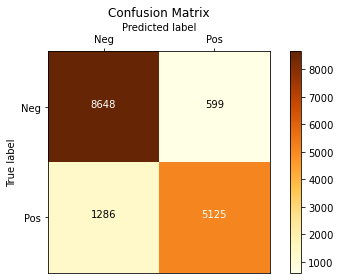

In [827]:
predicted = bc_gs.predict(test)
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))
draw_confusion_matrix(target_test, predicted, ['Neg', 'Pos'])

#### The bagging classifier shows a good training accuracy at 0.88, and also an amazing kaggle test accuracy at 0.878.

In [31]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

# Construct Grid Parameters
bc_params = {
    'n_estimators': [45], 
    'max_features': [0.8,1.0]
}

In [849]:
# Perform Grid Search
bc_gs = GridSearchCV(BaggingClassifier(random_state=0),
                 bc_params,
                 cv = 5,
                 scoring = 'accuracy')


bc = bc_gs.fit(train, target)

In [850]:
res= pd.DataFrame(bc_gs.cv_results_)
res

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       5.964046      0.180889         0.148737        0.017069   
1       8.445502      0.312050         0.208097        0.027744   
2      10.708703      0.230568         0.232176        0.025675   
3       7.852601      0.452566         0.144489        0.012866   
4      10.245371      0.175691         0.195407        0.021235   
5      13.493849      0.626776         0.242634        0.031372   

  param_max_features param_n_estimators  \
0                0.8                 45   
1                0.8                 60   
2                0.8                 80   
3                1.0                 45   
4                1.0                 60   
5                1.0                 80   

                                      params  split0_test_score  \
0  {'max_features': 0.8, 'n_estimators': 45}           0.874431   
1  {'max_features': 0.8, 'n_estimators': 60}           0.875948   
2  {'max_features': 0.8, 'n_estimators': 80}           0.876826   
3  {'max_features': 1.0, 'n_estimators': 45}           0.870600   
4  {'max_features': 1.0, 'n_estimators': 60}           0.870999   
5  {'max_features': 1.0, 'n_estimators': 80}           0.871398   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.873314           0.874262           0.879610           0.877056   
1           0.875070           0.876976           0.880089           0.874900   
2           0.877465           0.877774           0.879052           0.874262   
3           0.873872           0.871787           0.873463           0.872745   
4           0.875070           0.874262           0.873543           0.871787   
5           0.874910           0.874022           0.874102           0.874421   

   mean_test_score  std_test_score  rank_test_score  
0         0.875735        0.002302                3  
1         0.876597        0.001896                2  
2         0.877076        0.001583                1  
3         0.872493        0.001183                6  
4         0.873132        0.001521                5  
5         0.873771        0.001227                4

In [30]:
bc_gs = BaggingClassifier(base_estimator = clf_rf, n_estimators = 40, max_features = 0.8, random_state=0)
bc = bc_gs.fit(train, target)
predicted = bc_gs.predict(test)
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))
#draw_confusion_matrix(target_test, predicted, ['Neg', 'Pos'])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

Accuracy:    0.879103


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


NameError: name 'draw_confusion_matrix' is not defined

In [32]:
bc_gs = BaggingClassifier(n_estimators = 45, max_features = 0.8, random_state=0)
bc = bc_gs.fit(train, target)
predicted = bc_gs.predict(test)
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))
#draw_confusion_matrix(target_test, predicted, ['Neg', 'Pos'])

Accuracy:    0.879614


## Extra Credit 

We have provided an extra test dataset named "hotel_booking_test.csv" that does not have the target labels. Classify the samples in the dataset with your best model and write them into a csv file. Submit your csv file to our [Kaggle](https://www.kaggle.com/t/32882e5969cc4cae9e30b0987f53dd1d) contest. The website will specify your classification accuracy on the test set. We will award a bonus point for the project for every percentage point over 75% that you get on your kaggle test accuracy.

To get the bonus points, you must also write out a summary of the model that you submit including any changes you made to the pre-processing steps. The summary must be written in a markdown cell of the jupyter notebook. Note that you should not change earlier parts of the project to complete the extra credit. 

**Kaggle Submission Instruction**
Submit a two column csv where the first column is named "ID" and is the row number. The second column is named "target" and is the classification for each sample. Make sure that the sample order is preserved.

In [607]:
test_data = pd.read_csv('datasets/hotel_booking_test.csv')
test_data['children'].fillna(test_data['children'].mean(), inplace = True)
#Transform target feature into numerical

In [575]:

test_data.head()

hotel  lead_time arrival_date_month  stays_in_weekend_nights  \
0    City Hotel        177             August                        0   
1  Resort Hotel        217             August                        2   
2    City Hotel         65          September                        2   
3    City Hotel        377            October                        0   
4    City Hotel         75                May                        2   

   stays_in_week_nights  adults  children  babies meal country  ...  \
0                     2       2       0.0       0   SC     FRA  ...   
1                     5       2       1.0       0   HB     PRT  ...   
2                     1       2       0.0       0   HB     PRT  ...   
3                     2       2       0.0       0   HB     DEU  ...   
4                     1       2       0.0       0   BB     PRT  ...   

   booking_changes  deposit_type days_in_waiting_list    customer_type    adr  \
0                0    No Deposit                    0        Transient   94.5   
1                0    No Deposit                    0        Transient  170.0   
2                0    Non Refund                    0        Transient   86.0   
3                0    No Deposit                    0  Transient-Party  115.0   
4                0    No Deposit                    0  Transient-Party   90.0   

   required_car_parking_spaces total_of_special_requests             name  \
0                            0                         1  Wendy Moore DDS   
1                            0                         0   Brandon Fields   
2                            0                         0      Chad Peters   
3                            0                         1    Colin Rosario   
4                            0                         0       Dana Booth   

                          email  phone-number  
0             Wendy_D50@att.com  350-596-1114  
1              BFields@zoho.com  872-706-9025  
2       Peters.Chad@outlook.com  581-621-8941  
3  Rosario_Colin@protonmail.com  783-552-8468  
4      Dana_Booth22@outlook.com  194-105-9813  

[5 rows x 23 columns]

In [631]:
housing_features = test_data
housing_features = housing_features.drop(['name'],axis = 1).drop(['phone-number'],axis = 1).drop(['email'],axis = 1)

#cat_list = ['hotel','arrival_date_month','meal','country','reserved_room_type','deposit_type','customer_type','name','email','phone-number']
cat_list = ['hotel','arrival_date_month','meal','country','reserved_room_type','deposit_type','customer_type']
housing_features_num = housing_features
for features in cat_list:
    housing_features_num = housing_features_num.drop(features, axis=1)

In [632]:
#train_raw, test_raw, target, target_test = train_test_split(housing_features, housing_target, test_size=0.2, random_state = 1)
testk = full_pipeline.transform(housing_features)

#Since the pipeline num of features for OneHot encoding causes difference in features, we have to deal with it.
datasize, transformed_features = testk.shape
zeros = np.zeros((1,datasize)).transpose()
testk = np.concatenate((testk,zeros),axis =1)

In [634]:
log_reg = LogisticRegression(penalty = "l2",max_iter = 1000, solver = "lbfgs", C=0.1) 

log_reg.fit(train, target)

predicted = log_reg.predict(testk)
print(predicted)

[0 1 0 ... 0 0 1]


In [763]:
import csv
with open('predicted_log_1.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["ID", "target"])
    for i in range(len(predicted)):
        writer.writerow([i, predicted[i]])

In [764]:
testk.shape

(8699, 56)

In [771]:
predicted = svm.predict(testk)
print(predicted)

[0 1 0 ... 0 0 1]


In [772]:
with open('predicted_svm_all_data.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["ID", "target"])
    for i in range(len(predicted)):
        writer.writerow([i, predicted[i]])

In [770]:
predicted.shape

(8699,)

In [785]:
predicted = clf.predict(testk)
print(predicted)

[0 1 0 ... 0 0 0]


In [786]:
with open('predicted_svm_MLP_100100.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["ID", "target"])
    for i in range(len(predicted)):
        writer.writerow([i, predicted[i]])

In [ ]:
##Overfitting

In [798]:
predicted = knn.predict(testk)
print(predicted)

[0 1 1 ... 0 0 0]


In [799]:
with open('predicted_knn_n10_manh.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["ID", "target"])
    for i in range(len(predicted)):
        writer.writerow([i, predicted[i]])

In [822]:
predicted = clf_rf.predict(testk)
print(predicted)

with open('predicted_randomforest_n1500_d35.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["ID", "target"])
    for i in range(len(predicted)):
        writer.writerow([i, predicted[i]])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[0 1 1 ... 0 0 0]


[Parallel(n_jobs=1)]: Done 1500 out of 1500 | elapsed:    2.4s finished


In [852]:
predicted = bc_gs.predict(testk)
print(predicted)

[0 1 0 ... 0 0 0]


In [853]:
with open('predicted_bagging_n80.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["ID", "target"])
    for i in range(len(predicted)):
        writer.writerow([i, predicted[i]])